# 🦙 Meta-Llama 3.2-1B-Instruct — Decoder Model Internal Structure Analysis

---

**Model:** `meta-llama/Llama-3.2-1B-Instruct`  
**Architecture:** Decoder-Only Transformer (Causal Language Model)  
**Parameters:** ~1.24 Billion  
**Purpose:** ဒီ notebook မှာ Llama 3.2-1B-Instruct model ရဲ့ decoder architecture အတွင်းပိုင်း structure ကို အသေးစိတ်ခွဲခြမ်းစိတ်ဖြာလေ့လာပါမယ်။

### 📋 Table of Contents

1. **Environment Setup & Model Loading**
2. **High-Level Architecture Overview**
3. **Configuration Analysis**
4. **Tokenizer Deep Dive**
5. **Embedding Layer Analysis**
6. **Decoder Layer Structure**
   - 6.1 Self-Attention Mechanism (Grouped-Query Attention)
   - 6.2 RoPE (Rotary Position Embedding)
   - 6.3 Feed-Forward Network (MLP — SwiGLU)
   - 6.4 RMSNorm (Root Mean Square Layer Normalization)
7. **Parameter Statistics & Memory Analysis**
8. **Layer-by-Layer Weight Shape Inspection**
9. **Attention Pattern Visualization**
10. **Generation Pipeline & Inference Test**
11. **Summary & Key Findings**

In [13]:
from kaggle_secrets import UserSecretsClient

# Get the client
user_secrets = UserSecretsClient()

# This MUST match the Label in the Add-ons menu exactly (case-sensitive)
hf_token = user_secrets.get_secret("HF_TOKEN") 

print("Secret retrieved successfully!")

Secret retrieved successfully!


In [15]:
import os
from kaggle_secrets import UserSecretsClient
from huggingface_hub import login

# 1. Get the token
user_secrets = UserSecretsClient()
hf_token = user_secrets.get_secret("HF_TOKEN")

# 2. Login in Python
login(token=hf_token)

# 3. Force Login for the Shell/CLI
# This creates the physical token file that !huggingface-cli looks for
!mkdir -p ~/.cache/huggingface
!echo -n "{hf_token}" > ~/.cache/huggingface/token

print("Login sync complete!")

Login sync complete!


In [16]:
!hf auth whoami

user:  kyawswartun


---
## 1. 🔧 Environment Setup & Model Loading

Kaggle ပေါ်မှာ run ဖို့ လိုအပ်တဲ့ libraries တွေ install လုပ်ပြီး model ကို load ပါမယ်။

> **Kaggle Settings:** `Settings → Accelerator → GPU T4 x2` ကိုရွေးပါ။  
> **Hugging Face Token:** Kaggle Secrets မှာ `HF_TOKEN` ထည့်ထားပါ။

In [1]:
# Install / Upgrade required packages
!pip install -q transformers accelerate sentencepiece protobuf

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from collections import OrderedDict

from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    AutoConfig,
)

print(f"PyTorch version : {torch.__version__}")
print(f"CUDA available  : {torch.cuda.is_available()}")

if torch.cuda.is_available():
    # GPU အရေအတွက်ကို စစ်မယ် (Kaggle 2x T4 ဆိုရင် 2 လို့ ပြပါလိမ့်မယ်)
    device_count = torch.cuda.device_count()
    print(f"Found {device_count} GPU(s):")
    print("-" * 30)

    for i in range(device_count):
        device_props = torch.cuda.get_device_properties(i)
        gpu_name = torch.cuda.get_device_name(i)
        
        # PyTorch version အလိုက် total_memory သို့မဟုတ် total_mem ဖြစ်နိုင်လို့ check လုပ်ပေးထားပါတယ်
        if hasattr(device_props, 'total_memory'):
            total_mem = device_props.total_memory
        else:
            total_mem = device_props.total_mem
            
        gpu_memory_gb = total_mem / 1e9
        print(f"GPU {i} Device      : {gpu_name}")
        print(f"GPU {i} Memory      : {gpu_memory_gb:.2f} GB")
        print("-" * 30)
else:
    print("No GPU found. Please enable GPU in Kaggle settings.")

PyTorch version : 2.9.0+cu126
CUDA available  : True
Found 2 GPU(s):
------------------------------
GPU 0 Device      : Tesla T4
GPU 0 Memory      : 15.64 GB
------------------------------
GPU 1 Device      : Tesla T4
GPU 1 Memory      : 15.64 GB
------------------------------


In [5]:
# ─── Hugging Face Authentication ───
# Kaggle မှာ Secrets > Add Secret > Label: HF_TOKEN, Value: your_token

import os

# --- Method 1: Kaggle Secrets (Recommended) ---
try:
    from kaggle_secrets import UserSecretsClient
    secrets = UserSecretsClient()
    hf_token = secrets.get_secret("HF_TOKEN")
    print("✅ HF Token loaded from Kaggle Secrets")
except Exception:
    # --- Method 2: Environment Variable ---
    hf_token = os.environ.get("HF_TOKEN", None)
    if hf_token:
        print("✅ HF Token loaded from environment variable")
    else:
        print("⚠️  No HF Token found. Set it in Kaggle Secrets or as env var.")
        hf_token = None

✅ HF Token loaded from Kaggle Secrets


In [43]:
# ─── Model & Tokenizer Loading ───
MODEL_ID = "meta-llama/Llama-3.2-1B-Instruct"

print(f"Loading model: {MODEL_ID}")
print("=" * 60)

# Config ကို သီးသန့် load လုပ်ပါမယ် (memory မသုံးဘဲ architecture ကြည့်ဖို့)
config = AutoConfig.from_pretrained(MODEL_ID, token=hf_token)

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, token=hf_token)

# Full Model (float16 for memory efficiency)
# NOTE: attn_implementation="eager" is required to extract attention weights.
# The default "sdpa" backend does not return attention matrices.
model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    token=hf_token,
    dtype=torch.float16,
    device_map="auto",
    attn_implementation="eager",
)

model.eval()
print("\n✅ Model loaded successfully!")
print(f"Model dtype: {model.dtype}")
print(f"Device map : {model.hf_device_map}")

Loading model: meta-llama/Llama-3.2-1B-Instruct


Loading weights:   0%|          | 0/146 [00:00<?, ?it/s]


✅ Model loaded successfully!
Model dtype: torch.float16
Device map : {'model.embed_tokens': 0, 'lm_head': 0, 'model.layers.0': 0, 'model.layers.1': 0, 'model.layers.2': 0, 'model.layers.3': 0, 'model.layers.4': 0, 'model.layers.5': 0, 'model.layers.6': 1, 'model.layers.7': 1, 'model.layers.8': 1, 'model.layers.9': 1, 'model.layers.10': 1, 'model.layers.11': 1, 'model.layers.12': 1, 'model.layers.13': 1, 'model.layers.14': 1, 'model.layers.15': 1, 'model.norm': 1, 'model.rotary_emb': 1}


'model.layers.0' to 'model.layers.5': 0

    ဆိုလိုတာက ပထမဆုံး Layer ၆ ခုနဲ့ Model ရဲ့ အစပိုင်း (Embedding tokens) တွေကို GPU 0 ပေါ်မှာ တင်ထားပါတယ်။

'model.layers.6' to 'model.layers.15': 1

    ကျန်တဲ့ Layer ၁၀ ခုနဲ့ Model ရဲ့ အဆုံးသတ်ပိုင်း (Normalization နဲ့ Rotary Embeddings) တွေကို GPU 1 ပေါ်မှာ တင်ထားပါတယ်။

---
## 2. 🏗️ High-Level Architecture Overview

Llama 3.2-1B-Instruct ရဲ့ overall model structure ကို ကြည့်ပါမယ်။  
Decoder-Only Transformer ဖြစ်တဲ့အတွက် **Encoder မပါဘဲ** Decoder Layers တွေနဲ့ပဲ ဖွဲ့စည်းထားပါတယ်။

```
LlamaForCausalLM
├── model (LlamaModel)
│   ├── embed_tokens          → Token Embedding Layer
│   ├── layers[0..N-1]        → Stacked Decoder Layers
│   │   ├── self_attn         → Grouped-Query Attention (GQA)
│   │   ├── mlp               → SwiGLU Feed-Forward Network
│   │   ├── input_layernorm   → RMSNorm (Pre-Attention)
│   │   └── post_attention_layernorm → RMSNorm (Pre-FFN)
│   └── norm                  → Final RMSNorm
└── lm_head                   → Linear (Output Projection → Vocabulary)
```

In [7]:
# ─── Full Model Architecture Print ───
print("═" * 70)
print("  LLAMA 3.2-1B-INSTRUCT — FULL ARCHITECTURE")
print("═" * 70)
print(model)

══════════════════════════════════════════════════════════════════════
  LLAMA 3.2-1B-INSTRUCT — FULL ARCHITECTURE
══════════════════════════════════════════════════════════════════════
LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLUActivation()
        )
        (

In [8]:
# ─── Top-Level Module Names ───
print("\n📦 Top-Level Modules:")
print("-" * 50)
for name, module in model.named_children():
    print(f"  ├── {name}: {module.__class__.__name__}")

print("\n📦 Inside 'model' (LlamaModel):")
print("-" * 50)
for name, module in model.model.named_children():
    if name == "layers":
        print(f"  ├── {name}: {module.__class__.__name__} ({len(module)} decoder layers)")
    else:
        print(f"  ├── {name}: {module.__class__.__name__}")


📦 Top-Level Modules:
--------------------------------------------------
  ├── model: LlamaModel
  ├── lm_head: Linear

📦 Inside 'model' (LlamaModel):
--------------------------------------------------
  ├── embed_tokens: Embedding
  ├── layers: ModuleList (16 decoder layers)
  ├── norm: LlamaRMSNorm
  ├── rotary_emb: LlamaRotaryEmbedding


---
## 3. ⚙️ Configuration Analysis

Model ရဲ့ hyperparameters နဲ့ architecture configuration ကို အသေးစိတ်ကြည့်ပါမယ်။

In [10]:
# ─── Model Configuration ───
print("═" * 70)
print("  MODEL CONFIGURATION")
print("═" * 70)

config_dict = config.to_dict()

# Key architectural parameters
key_params = [
    ("Model Type", config_dict.get("model_type")),
    ("Architecture", config_dict.get("architectures")),
    ("Hidden Size (d_model)", config_dict.get("hidden_size")),
    ("Intermediate Size (FFN)", config_dict.get("intermediate_size")),
    ("Num Hidden Layers", config_dict.get("num_hidden_layers")),
    ("Num Attention Heads (Q)", config_dict.get("num_attention_heads")),
    ("Num Key-Value Heads (KV)", config_dict.get("num_key_value_heads")),
    ("Head Dimension", config_dict.get("head_dim", config_dict.get("hidden_size") // config_dict.get("num_attention_heads"))),
    ("Vocab Size", config_dict.get("vocab_size")),
    ("Max Position Embeddings", config_dict.get("max_position_embeddings")),
    ("RMS Norm Epsilon", config_dict.get("rms_norm_eps")),
    ("Hidden Activation (FFN)", config_dict.get("hidden_act")),
    ("Rope Theta", config_dict.get("rope_theta")),
    ("Tie Word Embeddings", config_dict.get("tie_word_embeddings")),
    ("Use Cache", config_dict.get("use_cache")),
    ("Torch Dtype", config_dict.get("torch_dtype")),
]

for param_name, param_value in key_params:
    print(f"  {param_name:<35} : {param_value}")

# GQA ratio calculation
n_heads = config_dict.get("num_attention_heads")
n_kv_heads = config_dict.get("num_key_value_heads")
gqa_ratio = n_heads // n_kv_heads
print(f"\n  {'GQA Group Ratio':<35} : {gqa_ratio} (Each {gqa_ratio} Q heads share 1 KV head)")
print(f"  {'Attention Type':<35} : {'Grouped-Query Attention (GQA)' if n_kv_heads < n_heads else 'Multi-Head Attention (MHA)'}")

══════════════════════════════════════════════════════════════════════
  MODEL CONFIGURATION
══════════════════════════════════════════════════════════════════════
  Model Type                          : llama
  Architecture                        : ['LlamaForCausalLM']
  Hidden Size (d_model)               : 2048
  Intermediate Size (FFN)             : 8192
  Num Hidden Layers                   : 16
  Num Attention Heads (Q)             : 32
  Num Key-Value Heads (KV)            : 8
  Head Dimension                      : 64
  Vocab Size                          : 128256
  Max Position Embeddings             : 131072
  RMS Norm Epsilon                    : 1e-05
  Hidden Activation (FFN)             : silu
  Rope Theta                          : None
  Tie Word Embeddings                 : True
  Use Cache                           : True
  Torch Dtype                         : None

  GQA Group Ratio                     : 4 (Each 4 Q heads share 1 KV head)
  Attention Type           

In [11]:
# ─── RoPE Scaling Configuration ───
print("\n🔄 RoPE (Rotary Position Embedding) Configuration:")
print("-" * 50)
rope_scaling = config_dict.get("rope_scaling", None)
if rope_scaling:
    for key, value in rope_scaling.items():
        print(f"  {key:<30} : {value}")
else:
    print(f"  Base theta: {config_dict.get('rope_theta')}")
    print("  No additional scaling applied.")


🔄 RoPE (Rotary Position Embedding) Configuration:
--------------------------------------------------
  Base theta: None
  No additional scaling applied.


In [12]:
# ─── Full Config Dump (for reference) ───
import json
print("\n📄 Full Configuration JSON:")
print(json.dumps(config_dict, indent=2, default=str))


📄 Full Configuration JSON:
{
  "vocab_size": 128256,
  "max_position_embeddings": 131072,
  "hidden_size": 2048,
  "intermediate_size": 8192,
  "num_hidden_layers": 16,
  "num_attention_heads": 32,
  "num_key_value_heads": 8,
  "hidden_act": "silu",
  "initializer_range": 0.02,
  "rms_norm_eps": 1e-05,
  "pretraining_tp": 1,
  "use_cache": true,
  "attention_bias": false,
  "attention_dropout": 0.0,
  "mlp_bias": false,
  "head_dim": 64,
  "rope_parameters": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_embeddings": 8192,
    "rope_type": "llama3",
    "rope_theta": 500000.0
  },
  "tie_word_embeddings": true,
  "pad_token_id": null,
  "bos_token_id": 128000,
  "eos_token_id": [
    128001,
    128008,
    128009
  ],
  "return_dict": true,
  "output_hidden_states": false,
  "dtype": "bfloat16",
  "chunk_size_feed_forward": 0,
  "is_encoder_decoder": false,
  "architectures": [
    "LlamaForCausalLM"
  ],
  "id2label": {
    

---
## 4. 📝 Tokenizer Deep Dive

Llama 3.2 မှာ **BPE (Byte-Pair Encoding)** based tokenizer ကို သုံးထားပါတယ်။  
Tokenizer ရဲ့ vocabulary size, special tokens, encoding/decoding behavior တွေကို စစ်ဆေးပါမယ်။

In [13]:
# ─── Tokenizer Information ───
print("═" * 70)
print("  TOKENIZER ANALYSIS")
print("═" * 70)

print(f"  Tokenizer class       : {tokenizer.__class__.__name__}")
print(f"  Vocabulary size       : {tokenizer.vocab_size:,}")
print(f"  Model max length      : {tokenizer.model_max_length:,}")
print(f"  Padding side          : {tokenizer.padding_side}")
print(f"  Truncation side       : {tokenizer.truncation_side}")
print(f"  Is fast tokenizer     : {tokenizer.is_fast}")

print("\n🔑 Special Tokens:")
print("-" * 50)
special_tokens = {
    "BOS (Begin of Sequence)": (tokenizer.bos_token, tokenizer.bos_token_id),
    "EOS (End of Sequence)": (tokenizer.eos_token, tokenizer.eos_token_id),
    "PAD (Padding)": (tokenizer.pad_token, tokenizer.pad_token_id),
    "UNK (Unknown)": (tokenizer.unk_token, getattr(tokenizer, 'unk_token_id', None)),
}

for name, (token, token_id) in special_tokens.items():
    print(f"  {name:<30} : token='{token}', id={token_id}")

# All special tokens
print("\n📋 All Special Tokens:")
for i, token in enumerate(tokenizer.all_special_tokens[:20]):
    token_id = tokenizer.convert_tokens_to_ids(token)
    print(f"  [{i:>3}] id={token_id:<10} → '{token}'")
if len(tokenizer.all_special_tokens) > 20:
    print(f"  ... and {len(tokenizer.all_special_tokens) - 20} more special tokens")

══════════════════════════════════════════════════════════════════════
  TOKENIZER ANALYSIS
══════════════════════════════════════════════════════════════════════
  Tokenizer class       : TokenizersBackend
  Vocabulary size       : 128,000
  Model max length      : 131,072
  Padding side          : right
  Truncation side       : right
  Is fast tokenizer     : True

🔑 Special Tokens:
--------------------------------------------------
  BOS (Begin of Sequence)        : token='<|begin_of_text|>', id=128000
  EOS (End of Sequence)          : token='<|eot_id|>', id=128009
  PAD (Padding)                  : token='None', id=None
  UNK (Unknown)                  : token='None', id=None

📋 All Special Tokens:
  [  0] id=128000     → '<|begin_of_text|>'
  [  1] id=128009     → '<|eot_id|>'


In [14]:
# ─── Tokenization Examples ───
print("\n🔤 Tokenization Examples:")
print("=" * 60)

test_texts = [
    "Hello, how are you?",
    "The capital of Myanmar is Naypyidaw.",
    "def fibonacci(n):\n    if n <= 1:\n        return n",
    "🦙 Llama model analysis!",
    "မင်္ဂလာပါ",  # Burmese text
]

for text in test_texts:
    tokens = tokenizer.tokenize(text)
    token_ids = tokenizer.encode(text, add_special_tokens=False)
    print(f"\n  Input   : '{text}'")
    print(f"  Tokens  : {tokens}")
    print(f"  IDs     : {token_ids}")
    print(f"  Count   : {len(tokens)} tokens")


🔤 Tokenization Examples:

  Input   : 'Hello, how are you?'
  Tokens  : ['Hello', ',', 'Ġhow', 'Ġare', 'Ġyou', '?']
  IDs     : [9906, 11, 1268, 527, 499, 30]
  Count   : 6 tokens

  Input   : 'The capital of Myanmar is Naypyidaw.'
  Tokens  : ['The', 'Ġcapital', 'Ġof', 'ĠMyanmar', 'Ġis', 'ĠNay', 'py', 'id', 'aw', '.']
  IDs     : [791, 6864, 315, 53455, 374, 99173, 3368, 307, 675, 13]
  Count   : 10 tokens

  Input   : 'def fibonacci(n):
    if n <= 1:
        return n'
  Tokens  : ['def', 'Ġfibonacci', '(n', '):Ċ', 'ĠĠĠ', 'Ġif', 'Ġn', 'Ġ<=', 'Ġ', '1', ':Ċ', 'ĠĠĠĠĠĠĠ', 'Ġreturn', 'Ġn']
  IDs     : [755, 76798, 1471, 997, 262, 422, 308, 2717, 220, 16, 512, 286, 471, 308]
  Count   : 14 tokens

  Input   : '🦙 Llama model analysis!'
  Tokens  : ['ðŁ', '¦', 'Ļ', 'ĠL', 'lama', 'Ġmodel', 'Ġanalysis', '!']
  IDs     : [9468, 99, 247, 445, 81101, 1646, 6492, 0]
  Count   : 8 tokens

  Input   : 'မင်္ဂလာပါ'
  Tokens  : ['áĢ', 'Ļ', 'áĢ', 'Ħ', 'áĢ', 'º', 'áĢ', '¹', 'áĢ', 'Ĥ', 'áĢ', 'ľ', 'áĢ', '

In [15]:
# ─── Chat Template ───
print("\n💬 Chat Template:")
print("-" * 60)

messages = [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": "What is deep learning?"},
]

chat_text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
print(chat_text)

chat_tokens = tokenizer.apply_chat_template(messages, tokenize=True, add_generation_prompt=True)
print(f"\nTotal tokens in chat prompt: {len(chat_tokens)}")


💬 Chat Template:
------------------------------------------------------------
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 28 Feb 2026

You are a helpful assistant.<|eot_id|><|start_header_id|>user<|end_header_id|>

What is deep learning?<|eot_id|><|start_header_id|>assistant<|end_header_id|>



Total tokens in chat prompt: 2


---
## 5. 📊 Embedding Layer Analysis

Model ရဲ့ input embedding layer ကို စစ်ဆေးပါမယ်။  
Llama 3.2 မှာ `embed_tokens` layer ကသာ token embeddings ကို handle လုပ်ပြီး  
**positional embeddings အတွက် RoPE** ကို attention layer ထဲမှာ apply လုပ်ပါတယ်  
(traditional absolute positional embedding မသုံးပါ)။

In [16]:
# ─── Embedding Layer Details ───
embed_layer = model.model.embed_tokens

print("═" * 70)
print("  EMBEDDING LAYER ANALYSIS")
print("═" * 70)
print(f"  Layer type           : {embed_layer.__class__.__name__}")
print(f"  Vocabulary size      : {embed_layer.num_embeddings:,}")
print(f"  Embedding dimension  : {embed_layer.embedding_dim}")
print(f"  Weight shape         : {embed_layer.weight.shape}")
print(f"  Weight dtype         : {embed_layer.weight.dtype}")
print(f"  Padding idx          : {embed_layer.padding_idx}")

# Parameter count
embed_params = embed_layer.weight.numel()
print(f"  Total parameters     : {embed_params:,}")
print(f"  Memory (FP16)        : {embed_params * 2 / 1e6:.2f} MB")
print(f"  Memory (FP32)        : {embed_params * 4 / 1e6:.2f} MB")

══════════════════════════════════════════════════════════════════════
  EMBEDDING LAYER ANALYSIS
══════════════════════════════════════════════════════════════════════
  Layer type           : Embedding
  Vocabulary size      : 128,256
  Embedding dimension  : 2048
  Weight shape         : torch.Size([128256, 2048])
  Weight dtype         : torch.float16
  Padding idx          : None
  Total parameters     : 262,668,288
  Memory (FP16)        : 525.34 MB
  Memory (FP32)        : 1050.67 MB


In [17]:
# ─── Embedding Weight Statistics ───
embed_weight = embed_layer.weight.detach().float()

print("\n📊 Embedding Weight Statistics:")
print("-" * 50)
print(f"  Mean               : {embed_weight.mean().item():.6f}")
print(f"  Std                : {embed_weight.std().item():.6f}")
print(f"  Min                : {embed_weight.min().item():.6f}")
print(f"  Max                : {embed_weight.max().item():.6f}")
print(f"  L2 Norm (avg/row)  : {embed_weight.norm(dim=1).mean().item():.6f}")


📊 Embedding Weight Statistics:
--------------------------------------------------
  Mean               : -0.000094
  Std                : 0.020644
  Min                : -0.312500
  Max                : 0.361328
  L2 Norm (avg/row)  : 0.929794


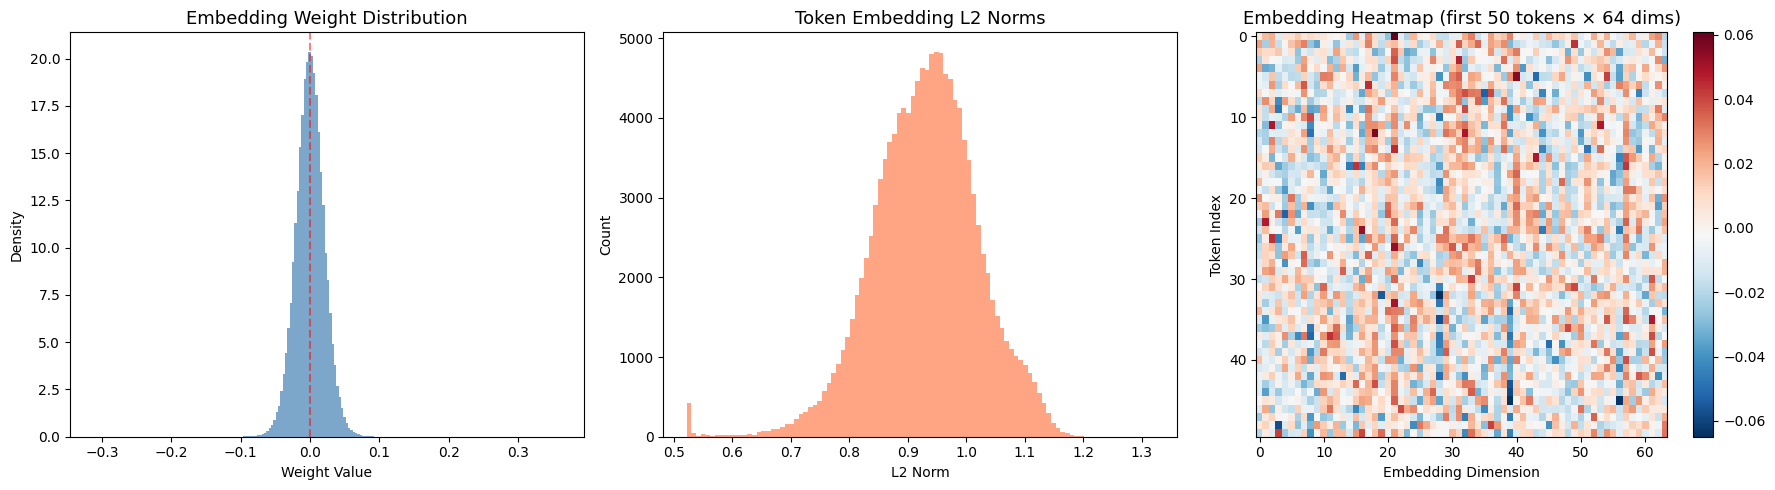

In [19]:
# ─── Embedding Visualization: Weight Distribution ───
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Overall weight distribution
axes[0].hist(embed_weight.cpu().numpy().flatten(), bins=200, color='steelblue', alpha=0.7, density=True)
axes[0].set_title('Embedding Weight Distribution', fontsize=13)
axes[0].set_xlabel('Weight Value')
axes[0].set_ylabel('Density')
axes[0].axvline(x=0, color='red', linestyle='--', alpha=0.5)

# 2. L2 Norm per token
norms = embed_weight.norm(dim=1).cpu().numpy()
axes[1].hist(norms, bins=100, color='coral', alpha=0.7)
axes[1].set_title('Token Embedding L2 Norms', fontsize=13)
axes[1].set_xlabel('L2 Norm')
axes[1].set_ylabel('Count')

# 3. Heatmap of first 50 tokens x first 64 dims
im = axes[2].imshow(embed_weight[:50, :64].cpu().numpy(), aspect='auto', cmap='RdBu_r')
axes[2].set_title('Embedding Heatmap (first 50 tokens × 64 dims)', fontsize=13)
axes[2].set_xlabel('Embedding Dimension')
axes[2].set_ylabel('Token Index')
plt.colorbar(im, ax=axes[2])

plt.tight_layout()
plt.show()

In [20]:
# ─── Weight Tying Check: embed_tokens vs lm_head ───
print("\n🔗 Weight Tying (embed_tokens ↔ lm_head):")
print("-" * 50)

tie_flag = config_dict.get("tie_word_embeddings", False)
print(f"  Config tie_word_embeddings : {tie_flag}")

if hasattr(model, 'lm_head') and model.lm_head.weight is not None:
    same_data = model.lm_head.weight.data_ptr() == model.model.embed_tokens.weight.data_ptr()
    print(f"  Same memory (data_ptr)    : {same_data}")
    print(f"  lm_head weight shape      : {model.lm_head.weight.shape}")
    print(f"  embed_tokens weight shape  : {model.model.embed_tokens.weight.shape}")
    if same_data:
        print("  ✅ Weights ARE tied — embed_tokens and lm_head share the same tensor")
    else:
        print("  ❌ Weights are NOT tied — separate tensors")
else:
    print("  lm_head not found or has no weight")


🔗 Weight Tying (embed_tokens ↔ lm_head):
--------------------------------------------------
  Config tie_word_embeddings : True
  Same memory (data_ptr)    : True
  lm_head weight shape      : torch.Size([128256, 2048])
  embed_tokens weight shape  : torch.Size([128256, 2048])
  ✅ Weights ARE tied — embed_tokens and lm_head share the same tensor


---
## 6. 🔍 Decoder Layer Structure — Deep Dive

Llama 3.2-1B-Instruct ရဲ့ decoder layer တစ်ခုချင်းစီရဲ့ internal components တွေကို အသေးစိတ်ခွဲကြည့်ပါမယ်။  
Decoder Layer တစ်ခုတိုင်းမှာ:

1. **RMSNorm** (Pre-Attention Normalization)
2. **Grouped-Query Self-Attention (GQA)**
3. **RMSNorm** (Pre-FFN Normalization)
4. **SwiGLU MLP** (Feed-Forward Network)
5. **Residual Connections** (Add)

In [21]:
# ─── Single Decoder Layer Breakdown ───
decoder_layers = model.model.layers
num_layers = len(decoder_layers)
layer_0 = decoder_layers[0]  # First decoder layer

print("═" * 70)
print(f"  DECODER LAYER STRUCTURE (Total: {num_layers} layers)")
print("═" * 70)
print(f"\n📐 Layer 0 Architecture:")
print(layer_0)

print(f"\n\n📦 Sub-modules in each Decoder Layer:")
print("-" * 50)
for name, module in layer_0.named_children():
    print(f"  ├── {name}: {module.__class__.__name__}")

══════════════════════════════════════════════════════════════════════
  DECODER LAYER STRUCTURE (Total: 16 layers)
══════════════════════════════════════════════════════════════════════

📐 Layer 0 Architecture:
LlamaDecoderLayer(
  (self_attn): LlamaAttention(
    (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
    (k_proj): Linear(in_features=2048, out_features=512, bias=False)
    (v_proj): Linear(in_features=2048, out_features=512, bias=False)
    (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
  )
  (mlp): LlamaMLP(
    (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
    (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
    (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
    (act_fn): SiLUActivation()
  )
  (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
  (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
)


📦 Sub-modules in each Decoder Layer:
---------------------------

### 6.1 🧠 Self-Attention Mechanism — Grouped-Query Attention (GQA)

Llama 3.2 မှာ **Grouped-Query Attention (GQA)** ကို သုံးထားပါတယ်:
- **Multi-Head Attention (MHA):** Q, K, V heads အရေအတွက် အတူတူ
- **Multi-Query Attention (MQA):** KV head 1 ခုပဲ
- **Grouped-Query Attention (GQA):** Q heads ကို groups ခွဲပြီး group တစ်ခုစီကို KV head 1 ခုနဲ့ share

GQA ကြောင့် KV cache memory ကို သိသိသာသာ လျှော့ချနိုင်ပြီး inference speed ပိုမြန်ပါတယ်။

In [22]:
# ─── Attention Module Deep Dive ───
attn = layer_0.self_attn

print("═" * 70)
print("  GROUPED-QUERY ATTENTION (GQA) ANALYSIS")
print("═" * 70)
print(f"  Attention class         : {attn.__class__.__name__}")

# Dimensions
hidden_size = config.hidden_size
num_heads = config.num_attention_heads
num_kv_heads = config.num_key_value_heads
head_dim = hidden_size // num_heads

print(f"\n  Hidden size (d_model)   : {hidden_size}")
print(f"  Num Q heads             : {num_heads}")
print(f"  Num KV heads            : {num_kv_heads}")
print(f"  Head dimension          : {head_dim}")
print(f"  GQA group size          : {num_heads // num_kv_heads}")
print(f"  Q total dim             : {num_heads} × {head_dim} = {num_heads * head_dim}")
print(f"  K total dim             : {num_kv_heads} × {head_dim} = {num_kv_heads * head_dim}")
print(f"  V total dim             : {num_kv_heads} × {head_dim} = {num_kv_heads * head_dim}")

print(f"\n📏 Projection Weight Shapes:")
print("-" * 50)
for proj_name in ['q_proj', 'k_proj', 'v_proj', 'o_proj']:
    proj = getattr(attn, proj_name)
    w_shape = proj.weight.shape
    has_bias = proj.bias is not None
    params = proj.weight.numel() + (proj.bias.numel() if has_bias else 0)
    print(f"  {proj_name:<10} : weight={str(w_shape):<20} bias={str(has_bias):<8} params={params:,}")

══════════════════════════════════════════════════════════════════════
  GROUPED-QUERY ATTENTION (GQA) ANALYSIS
══════════════════════════════════════════════════════════════════════
  Attention class         : LlamaAttention

  Hidden size (d_model)   : 2048
  Num Q heads             : 32
  Num KV heads            : 8
  Head dimension          : 64
  GQA group size          : 4
  Q total dim             : 32 × 64 = 2048
  K total dim             : 8 × 64 = 512
  V total dim             : 8 × 64 = 512

📏 Projection Weight Shapes:
--------------------------------------------------
  q_proj     : weight=torch.Size([2048, 2048]) bias=False    params=4,194,304
  k_proj     : weight=torch.Size([512, 2048]) bias=False    params=1,048,576
  v_proj     : weight=torch.Size([512, 2048]) bias=False    params=1,048,576
  o_proj     : weight=torch.Size([2048, 2048]) bias=False    params=4,194,304


In [23]:
# ─── GQA vs MHA Comparison Diagram ───
print("\n📊 GQA vs MHA — Memory Savings Comparison:")
print("=" * 60)

# MHA (if all heads had separate KV)
mha_kv_params = 2 * num_heads * head_dim * hidden_size  # K + V projections
# GQA (shared KV heads)
gqa_kv_params = 2 * num_kv_heads * head_dim * hidden_size
savings = (1 - gqa_kv_params / mha_kv_params) * 100

print(f"  MHA KV projection params : {mha_kv_params:>12,}")
print(f"  GQA KV projection params : {gqa_kv_params:>12,}")
print(f"  Parameter savings        : {savings:.1f}%")

# KV Cache savings per token
seq_len = 1024
mha_kv_cache = 2 * num_heads * head_dim * seq_len * 2  # fp16
gqa_kv_cache = 2 * num_kv_heads * head_dim * seq_len * 2
print(f"\n  KV Cache per layer @ seq_len={seq_len} (FP16):")
print(f"    MHA: {mha_kv_cache / 1e6:.2f} MB  |  GQA: {gqa_kv_cache / 1e6:.2f} MB  |  Savings: {(1 - gqa_kv_cache/mha_kv_cache)*100:.1f}%")
print(f"  Total KV Cache ({num_layers} layers):")
print(f"    MHA: {mha_kv_cache * num_layers / 1e6:.2f} MB  |  GQA: {gqa_kv_cache * num_layers / 1e6:.2f} MB")


📊 GQA vs MHA — Memory Savings Comparison:
  MHA KV projection params :    8,388,608
  GQA KV projection params :    2,097,152
  Parameter savings        : 75.0%

  KV Cache per layer @ seq_len=1024 (FP16):
    MHA: 8.39 MB  |  GQA: 2.10 MB  |  Savings: 75.0%
  Total KV Cache (16 layers):
    MHA: 134.22 MB  |  GQA: 33.55 MB


In [24]:
# ─── Attention Weight Statistics per Layer ───
print("\n📊 Q/K/V/O Projection — Weight Statistics Across All Layers:")
print("=" * 80)
print(f"{'Layer':<8} {'Proj':<8} {'Mean':>10} {'Std':>10} {'Min':>10} {'Max':>10} {'Norm':>10}")
print("-" * 80)

for layer_idx in [0, num_layers // 4, num_layers // 2, 3 * num_layers // 4, num_layers - 1]:
    layer = decoder_layers[layer_idx]
    for proj_name in ['q_proj', 'k_proj', 'v_proj', 'o_proj']:
        w = getattr(layer.self_attn, proj_name).weight.detach().float()
        print(f"  L{layer_idx:<5} {proj_name:<8} {w.mean().item():>10.6f} {w.std().item():>10.6f} "
              f"{w.min().item():>10.6f} {w.max().item():>10.6f} {w.norm().item():>10.4f}")


📊 Q/K/V/O Projection — Weight Statistics Across All Layers:
Layer    Proj           Mean        Std        Min        Max       Norm
--------------------------------------------------------------------------------
  L0     q_proj    -0.000002   0.036056  -0.675781   0.582031    73.8433
  L0     k_proj    -0.000029   0.046726  -0.570312   0.644531    47.8472
  L0     v_proj     0.000000   0.009177  -0.060791   0.065430     9.3968
  L0     o_proj    -0.000003   0.011475  -0.314453   0.302734    23.5005
  L4     q_proj     0.000021   0.026279  -0.363281   0.341797    53.8197
  L4     k_proj     0.000012   0.035917  -0.416016   0.355469    36.7794
  L4     v_proj    -0.000009   0.013035  -0.118652   0.103516    13.3477
  L4     o_proj    -0.000008   0.014650  -0.339844   0.398438    30.0036
  L8     q_proj    -0.000018   0.024983  -0.462891   0.480469    51.1659
  L8     k_proj     0.000019   0.037568  -0.498047   0.447266    38.4701
  L8     v_proj    -0.000013   0.012628  -0.087402   0.

### 6.2 🔄 RoPE — Rotary Position Embedding

Llama 3.2 မှာ absolute positional embedding အစား **RoPE (Rotary Position Embedding)** ကို သုံးထားပါတယ်။

**RoPE ရဲ့ အဓိက အားသာချက်များ:**
- Position information ကို attention computation ထဲမှာ rotation matrix အနေနဲ့ inject လုပ်
- Relative position information ကို naturally encode လုပ်နိုင်
- Sequence length extrapolation ပိုကောင်း
- Q, K vectors ပေါ်မှာသာ apply (V ပေါ်မှာ apply မလုပ်)

In [48]:
# ─── RoPE Analysis ───
print("═" * 70)
print("  RoPE (ROTARY POSITION EMBEDDING) ANALYSIS")
print("═" * 70)

# rope_theta may be a top-level attribute or nested inside rope_scaling depending on transformers version
rope_theta = config_dict.get("rope_theta", None)
if rope_theta is None:
    rope_scaling = config_dict.get("rope_scaling", {}) or {}
    rope_theta = rope_scaling.get("rope_theta", 500_000.0)  # Llama 3.2 default

print(f"  Base theta             : {rope_theta:,.0f}")
print(f"  Head dimension         : {head_dim}")
print(f"  Max position           : {config.max_position_embeddings:,}")

# Compute RoPE frequencies
dim = head_dim
freqs = 1.0 / (rope_theta ** (torch.arange(0, dim, 2).float() / dim))
print(f"\n  Number of frequency pairs: {len(freqs)}")
print(f"  Frequency range: [{freqs.min().item():.2e}, {freqs.max().item():.2e}]")

# Wavelengths
wavelengths = 2 * np.pi / freqs.numpy()
print(f"  Wavelength range: [{wavelengths.min():.2f}, {wavelengths.max():.2f}] positions")


══════════════════════════════════════════════════════════════════════
  RoPE (ROTARY POSITION EMBEDDING) ANALYSIS
══════════════════════════════════════════════════════════════════════
  Base theta             : 500,000
  Head dimension         : 64
  Max position           : 131,072

  Number of frequency pairs: 32
  Frequency range: [3.01e-06, 1.00e+00]
  Wavelength range: [6.28, 2084764.88] positions


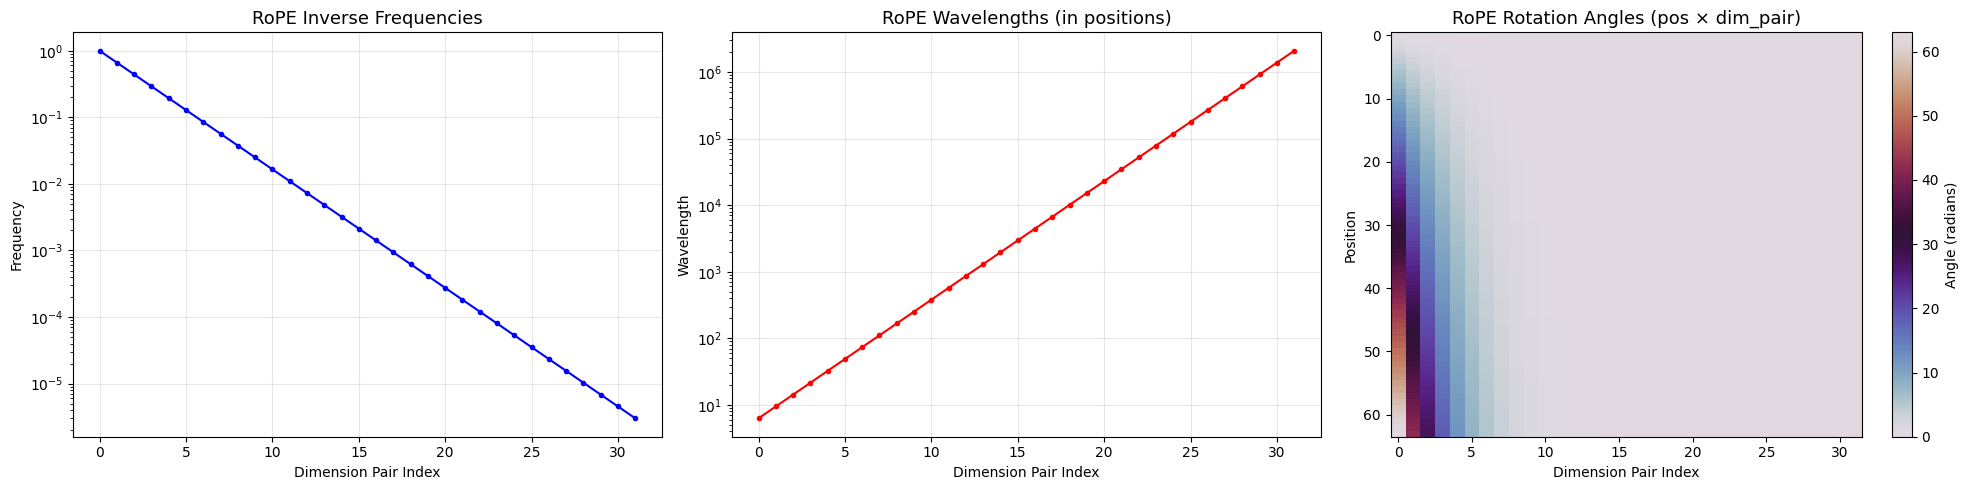

In [27]:
# ─── RoPE Frequency Visualization ───
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# 1. Inverse Frequencies
axes[0].plot(freqs.numpy(), 'b-o', markersize=3)
axes[0].set_title('RoPE Inverse Frequencies', fontsize=13)
axes[0].set_xlabel('Dimension Pair Index')
axes[0].set_ylabel('Frequency')
axes[0].set_yscale('log')
axes[0].grid(True, alpha=0.3)

# 2. Wavelengths (in positions)
axes[1].plot(wavelengths, 'r-o', markersize=3)
axes[1].set_title('RoPE Wavelengths (in positions)', fontsize=13)
axes[1].set_xlabel('Dimension Pair Index')
axes[1].set_ylabel('Wavelength')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)

# 3. RoPE rotation angles for different positions
positions = torch.arange(0, 128)
angles = torch.outer(positions.float(), freqs)
im = axes[2].imshow(angles.numpy()[:64, :], aspect='auto', cmap='twilight')
axes[2].set_title('RoPE Rotation Angles (pos × dim_pair)', fontsize=13)
axes[2].set_xlabel('Dimension Pair Index')
axes[2].set_ylabel('Position')
plt.colorbar(im, ax=axes[2], label='Angle (radians)')

plt.tight_layout()
plt.show()

### 6.3 🧮 Feed-Forward Network — SwiGLU MLP

Llama 3.2 ရဲ့ FFN (Feed-Forward Network) မှာ **SwiGLU activation** ကို သုံးထားပါတယ်။

**Traditional FFN:**  
$\text{FFN}(x) = W_2 \cdot \text{ReLU}(W_1 \cdot x)$

**SwiGLU FFN (Llama):**  
$\text{FFN}(x) = W_{\text{down}} \cdot (\text{SiLU}(W_{\text{gate}} \cdot x) \odot (W_{\text{up}} \cdot x))$

where $\text{SiLU}(x) = x \cdot \sigma(x)$ and $\odot$ is element-wise multiplication.

3 weight matrices ပါဝင်: `gate_proj`, `up_proj`, `down_proj`

In [28]:
# ─── MLP / FFN Analysis ───
mlp = layer_0.mlp

print("═" * 70)
print("  SwiGLU MLP (FEED-FORWARD NETWORK) ANALYSIS")
print("═" * 70)
print(f"  MLP class             : {mlp.__class__.__name__}")
print(f"  Activation function   : {mlp.act_fn.__class__.__name__} (SiLU / Swish)")

print(f"\n📏 MLP Projection Shapes:")
print("-" * 60)
for proj_name in ['gate_proj', 'up_proj', 'down_proj']:
    proj = getattr(mlp, proj_name)
    w_shape = proj.weight.shape
    has_bias = proj.bias is not None
    params = proj.weight.numel()
    print(f"  {proj_name:<12} : weight={str(w_shape):<25} bias={str(has_bias):<8} params={params:,}")

intermediate_size = config.intermediate_size
expansion_ratio = intermediate_size / hidden_size
print(f"\n  Hidden size          : {hidden_size}")
print(f"  Intermediate size    : {intermediate_size}")
print(f"  Expansion ratio      : {expansion_ratio:.2f}x")

# SwiGLU has 3 matrices instead of 2, effective ratio:
effective_params = 3 * hidden_size * intermediate_size
standard_params = 2 * hidden_size * (int(hidden_size * 4))  # standard 4x expansion with 2 matrices
print(f"\n  SwiGLU MLP params (per layer) : {effective_params:,}")
print(f"  Standard FFN params (4x, 2 matrices): {standard_params:,}")

══════════════════════════════════════════════════════════════════════
  SwiGLU MLP (FEED-FORWARD NETWORK) ANALYSIS
══════════════════════════════════════════════════════════════════════
  MLP class             : LlamaMLP
  Activation function   : SiLUActivation (SiLU / Swish)

📏 MLP Projection Shapes:
------------------------------------------------------------
  gate_proj    : weight=torch.Size([8192, 2048])  bias=False    params=16,777,216
  up_proj      : weight=torch.Size([8192, 2048])  bias=False    params=16,777,216
  down_proj    : weight=torch.Size([2048, 8192])  bias=False    params=16,777,216

  Hidden size          : 2048
  Intermediate size    : 8192
  Expansion ratio      : 4.00x

  SwiGLU MLP params (per layer) : 50,331,648
  Standard FFN params (4x, 2 matrices): 33,554,432


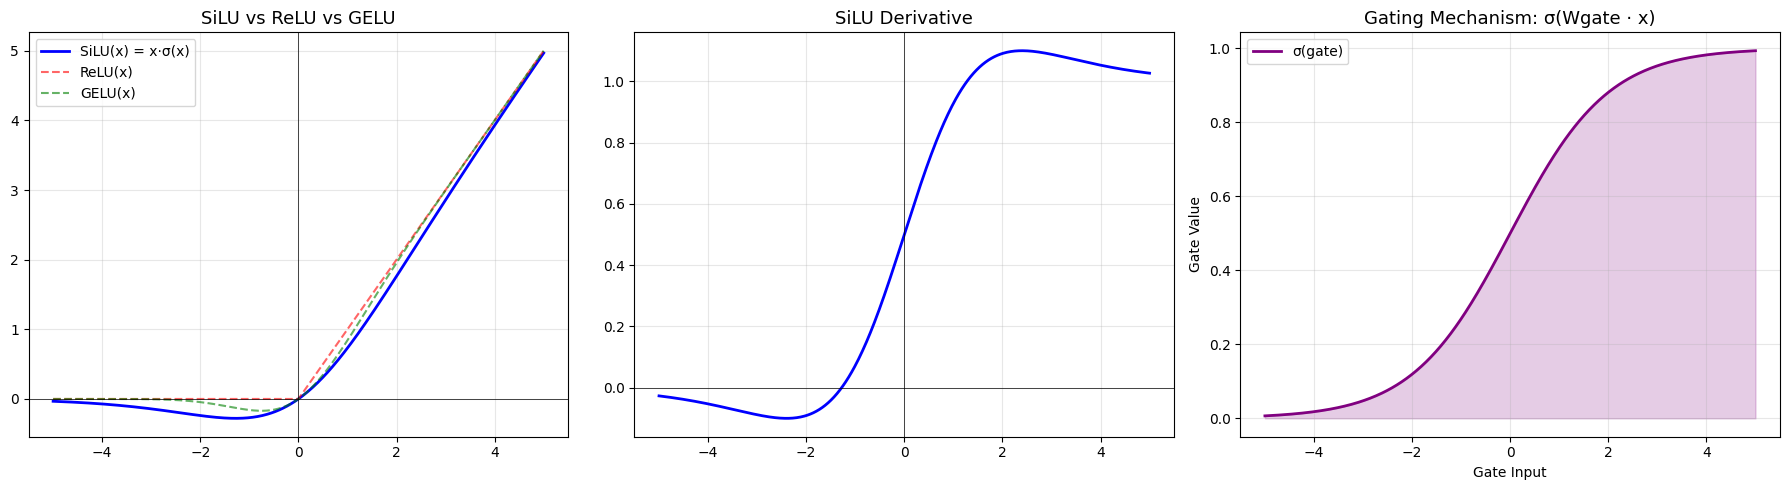

In [29]:
# ─── SwiGLU Activation Visualization ───
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

x = torch.linspace(-5, 5, 500)

# SiLU (Swish)
silu = x * torch.sigmoid(x)
axes[0].plot(x.numpy(), silu.numpy(), 'b-', linewidth=2, label='SiLU(x) = x·σ(x)')
axes[0].plot(x.numpy(), torch.relu(x).numpy(), 'r--', linewidth=1.5, alpha=0.6, label='ReLU(x)')
axes[0].plot(x.numpy(), torch.nn.functional.gelu(x).numpy(), 'g--', linewidth=1.5, alpha=0.6, label='GELU(x)')
axes[0].set_title('SiLU vs ReLU vs GELU', fontsize=13)
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=0, color='black', linewidth=0.5)
axes[0].axvline(x=0, color='black', linewidth=0.5)

# SiLU derivative
x_grad = x.clone().requires_grad_(True)
silu_grad = torch.autograd.grad(
    (x_grad * torch.sigmoid(x_grad)).sum(), x_grad
)[0]
axes[1].plot(x.numpy(), silu_grad.detach().numpy(), 'b-', linewidth=2)
axes[1].set_title('SiLU Derivative', fontsize=13)
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0, color='black', linewidth=0.5)
axes[1].axvline(x=0, color='black', linewidth=0.5)

# Gate mechanism illustration
gate_vals = torch.sigmoid(x)
axes[2].plot(x.numpy(), gate_vals.numpy(), 'purple', linewidth=2, label='σ(gate)')
axes[2].fill_between(x.numpy(), gate_vals.numpy(), alpha=0.2, color='purple')
axes[2].set_title('Gating Mechanism: σ(Wgate · x)', fontsize=13)
axes[2].set_xlabel('Gate Input')
axes[2].set_ylabel('Gate Value')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 6.4 📐 RMSNorm — Root Mean Square Layer Normalization

Llama 3.2 မှာ standard LayerNorm အစား **RMSNorm** ကို သုံးထားပါတယ်။

**LayerNorm:**  
$\text{LN}(x) = \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}} \cdot \gamma + \beta$

**RMSNorm:**  
$\text{RMSNorm}(x) = \frac{x}{\sqrt{\frac{1}{n}\sum_{i=1}^{n}x_i^2 + \epsilon}} \cdot \gamma$

**RMSNorm ရဲ့ အားသာချက်:**
- Mean subtraction မလိုတဲ့အတွက် computation ပိုမြန်
- Bias term ($\beta$) မပါ
- Re-centering ထက် re-scaling ကိုပဲ focus လုပ်

In [30]:
# ─── RMSNorm Analysis ───
print("═" * 70)
print("  RMSNorm ANALYSIS")
print("═" * 70)

# Pre-attention norm
input_norm = layer_0.input_layernorm
post_attn_norm = layer_0.post_attention_layernorm
final_norm = model.model.norm

print(f"  Per-layer RMSNorm locations:")
print(f"    1. input_layernorm       : {input_norm.__class__.__name__}  (Before Self-Attention)")
print(f"    2. post_attention_layernorm: {post_attn_norm.__class__.__name__}  (Before MLP/FFN)")
print(f"  Final RMSNorm              : {final_norm.__class__.__name__}  (After all decoder layers)")

print(f"\n📏 RMSNorm Parameters:")
print("-" * 50)
print(f"  Weight (gamma) shape   : {input_norm.weight.shape}")
print(f"  Epsilon                : {input_norm.variance_epsilon}")
print(f"  Learnable params       : {input_norm.weight.numel():,} (per norm layer)")

total_rmsnorm_count = num_layers * 2 + 1  # 2 per layer + 1 final
total_rmsnorm_params = total_rmsnorm_count * input_norm.weight.numel()
print(f"  Total RMSNorm layers   : {total_rmsnorm_count}")
print(f"  Total RMSNorm params   : {total_rmsnorm_params:,}")

══════════════════════════════════════════════════════════════════════
  RMSNorm ANALYSIS
══════════════════════════════════════════════════════════════════════
  Per-layer RMSNorm locations:
    1. input_layernorm       : LlamaRMSNorm  (Before Self-Attention)
    2. post_attention_layernorm: LlamaRMSNorm  (Before MLP/FFN)
  Final RMSNorm              : LlamaRMSNorm  (After all decoder layers)

📏 RMSNorm Parameters:
--------------------------------------------------
  Weight (gamma) shape   : torch.Size([2048])
  Epsilon                : 1e-05
  Learnable params       : 2,048 (per norm layer)
  Total RMSNorm layers   : 33
  Total RMSNorm params   : 67,584


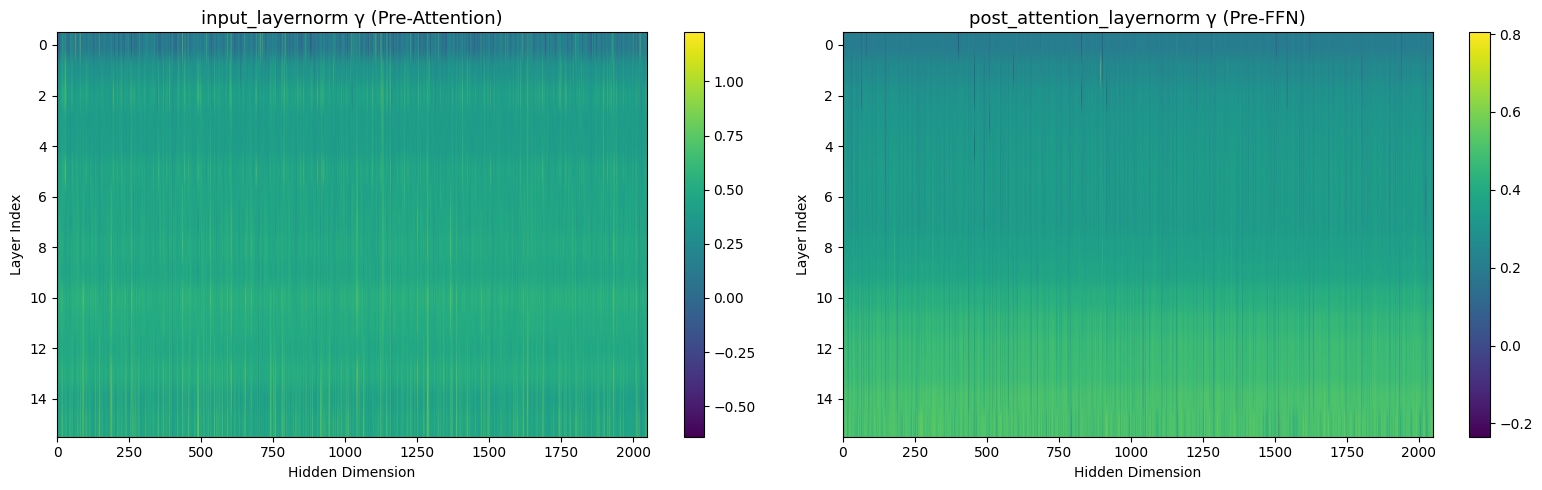

In [31]:
# ─── RMSNorm Gamma (Weight) Distribution Across Layers ───
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Collect gamma values
input_norm_gammas = []
post_attn_norm_gammas = []
for i in range(num_layers):
    input_norm_gammas.append(decoder_layers[i].input_layernorm.weight.detach().float().cpu().numpy())
    post_attn_norm_gammas.append(decoder_layers[i].post_attention_layernorm.weight.detach().float().cpu().numpy())

input_norm_gammas = np.array(input_norm_gammas)
post_attn_norm_gammas = np.array(post_attn_norm_gammas)

# Heatmap — input_layernorm
im1 = axes[0].imshow(input_norm_gammas, aspect='auto', cmap='viridis')
axes[0].set_title('input_layernorm γ (Pre-Attention)', fontsize=13)
axes[0].set_xlabel('Hidden Dimension')
axes[0].set_ylabel('Layer Index')
plt.colorbar(im1, ax=axes[0])

# Heatmap — post_attention_layernorm
im2 = axes[1].imshow(post_attn_norm_gammas, aspect='auto', cmap='viridis')
axes[1].set_title('post_attention_layernorm γ (Pre-FFN)', fontsize=13)
axes[1].set_xlabel('Hidden Dimension')
axes[1].set_ylabel('Layer Index')
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

---
## 7. 📈 Parameter Statistics & Memory Analysis

Model တစ်ခုလုံးရဲ့ parameter count, memory footprint, component-wise breakdown တွေကို တွက်ချက်ပါမယ်။

In [32]:
# ─── Total Parameter Count ───
print("═" * 70)
print("  PARAMETER STATISTICS")
print("═" * 70)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable = total_params - trainable_params

print(f"  Total parameters       : {total_params:>15,}  ({total_params/1e9:.3f} B)")
print(f"  Trainable parameters   : {trainable_params:>15,}  ({trainable_params/1e9:.3f} B)")
print(f"  Non-trainable params   : {non_trainable:>15,}")

# Memory estimation
print(f"\n💾 Memory Estimation:")
print("-" * 50)
for dtype_name, bytes_per_param in [("FP32", 4), ("FP16/BF16", 2), ("INT8", 1), ("INT4", 0.5)]:
    mem_gb = total_params * bytes_per_param / 1e9
    print(f"  {dtype_name:<12} : {mem_gb:.2f} GB")

══════════════════════════════════════════════════════════════════════
  PARAMETER STATISTICS
══════════════════════════════════════════════════════════════════════
  Total parameters       :   1,235,814,400  (1.236 B)
  Trainable parameters   :   1,235,814,400  (1.236 B)
  Non-trainable params   :               0

💾 Memory Estimation:
--------------------------------------------------
  FP32         : 4.94 GB
  FP16/BF16    : 2.47 GB
  INT8         : 1.24 GB
  INT4         : 0.62 GB


In [49]:
# ─── Component-wise Parameter Breakdown ───
print("\n📊 Component-wise Parameter Breakdown:")
print("=" * 70)

component_params = OrderedDict()

# Embedding
embed_p = sum(p.numel() for p in model.model.embed_tokens.parameters())
component_params['Embedding (embed_tokens)'] = embed_p

# Per-layer breakdown (using layer 0 as representative)
attn_params_per_layer = sum(p.numel() for p in layer_0.self_attn.parameters())
mlp_params_per_layer = sum(p.numel() for p in layer_0.mlp.parameters())
norm_params_per_layer = (
    sum(p.numel() for p in layer_0.input_layernorm.parameters()) +
    sum(p.numel() for p in layer_0.post_attention_layernorm.parameters())
)

component_params[f'Self-Attention (×{num_layers})'] = attn_params_per_layer * num_layers
component_params[f'MLP/FFN (×{num_layers})'] = mlp_params_per_layer * num_layers
component_params[f'RMSNorm (×{num_layers}×2 + 1)'] = norm_params_per_layer * num_layers + sum(p.numel() for p in model.model.norm.parameters())

# lm_head
if not config.tie_word_embeddings:
    lm_head_p = sum(p.numel() for p in model.lm_head.parameters())
    component_params['LM Head (lm_head)'] = lm_head_p
else:
    component_params['LM Head (tied with embedding)'] = 0

for name, count in component_params.items():
    pct = count / total_params * 100
    bar = '█' * int(pct / 2) + '░' * (50 - int(pct / 2))
    print(f"  {name:<35} : {count:>12,} ({pct:>5.1f}%) {bar}")

print(f"\n  {'TOTAL':<35} : {total_params:>12,}")

# Sub-breakdown per layer
print(f"\n  📐 Per Decoder Layer:")
print(f"    Self-Attention : {attn_params_per_layer:>10,} ({attn_params_per_layer/1e6:.2f}M)")
print(f"    MLP/FFN        : {mlp_params_per_layer:>10,} ({mlp_params_per_layer/1e6:.2f}M)")
print(f"    RMSNorm (×2)   : {norm_params_per_layer:>10,} ({norm_params_per_layer/1e6:.4f}M)")
layer_total = attn_params_per_layer + mlp_params_per_layer + norm_params_per_layer
print(f"    Layer Total    : {layer_total:>10,} ({layer_total/1e6:.2f}M)")


📊 Component-wise Parameter Breakdown:
  Embedding (embed_tokens)            :  262,668,288 ( 21.3%) ██████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
  Self-Attention (×16)                :  167,772,160 ( 13.6%) ██████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
  MLP/FFN (×16)                       :  805,306,368 ( 65.2%) ████████████████████████████████░░░░░░░░░░░░░░░░░░
  RMSNorm (×16×2 + 1)                 :       67,584 (  0.0%) ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
  LM Head (tied with embedding)       :            0 (  0.0%) ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░

  TOTAL                               : 1,235,814,400

  📐 Per Decoder Layer:
    Self-Attention : 10,485,760 (10.49M)
    MLP/FFN        : 50,331,648 (50.33M)
    RMSNorm (×2)   :      4,096 (0.0041M)
    Layer Total    : 60,821,504 (60.82M)


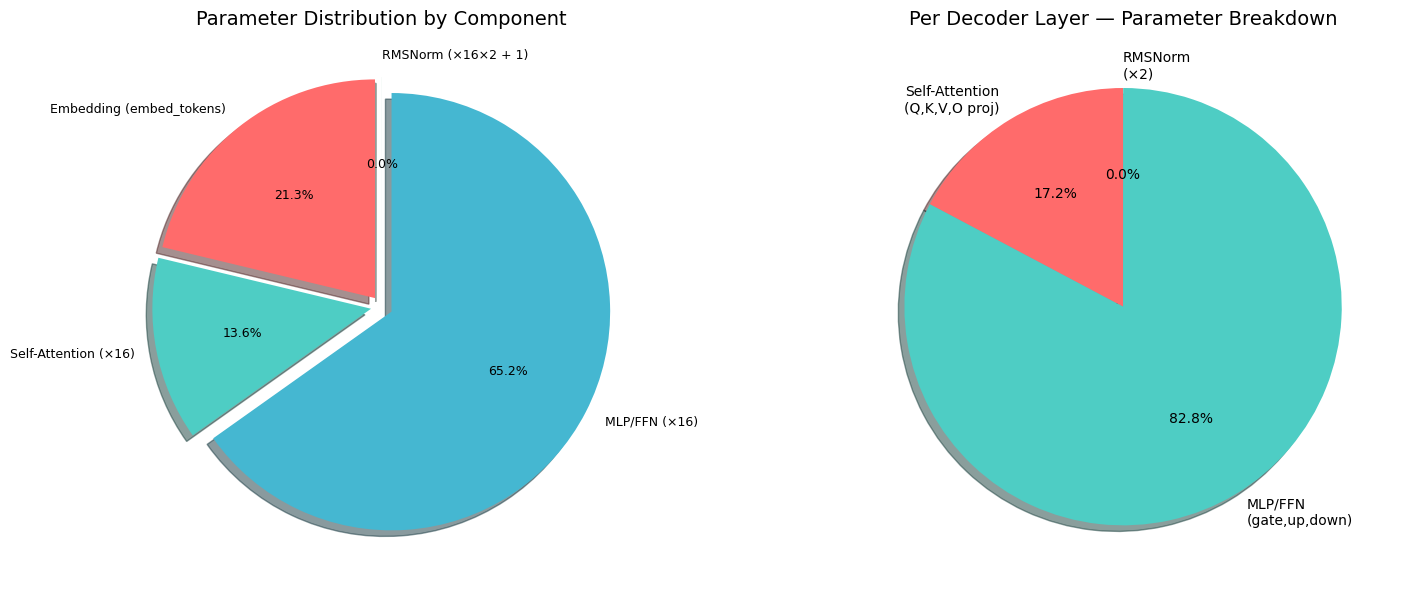

In [34]:
# ─── Parameter Distribution Pie Chart ───
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Overall component distribution
labels = [k for k, v in component_params.items() if v > 0]
sizes = [v for v in component_params.values() if v > 0]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']
explode = [0.05] * len(sizes)

axes[0].pie(sizes, explode=explode, labels=labels, colors=colors[:len(sizes)],
            autopct='%1.1f%%', shadow=True, startangle=90,
            textprops={'fontsize': 9})
axes[0].set_title('Parameter Distribution by Component', fontsize=14)

# 2. Per-layer breakdown
layer_labels = ['Self-Attention\n(Q,K,V,O proj)', 'MLP/FFN\n(gate,up,down)', 'RMSNorm\n(×2)']
layer_sizes = [attn_params_per_layer, mlp_params_per_layer, norm_params_per_layer]
layer_colors = ['#FF6B6B', '#4ECDC4', '#96CEB4']

axes[1].pie(layer_sizes, labels=layer_labels, colors=layer_colors,
            autopct='%1.1f%%', shadow=True, startangle=90,
            textprops={'fontsize': 10})
axes[1].set_title('Per Decoder Layer — Parameter Breakdown', fontsize=14)

plt.tight_layout()
plt.show()

---
## 8. 🔬 Layer-by-Layer Weight Shape Inspection

Model ရဲ့ named parameters အားလုံးကို layer-by-layer စစ်ဆေးပါမယ်။

In [35]:
# ─── All Named Parameters ───
print("═" * 90)
print("  ALL NAMED PARAMETERS — SHAPES & SIZES")
print("═" * 90)
print(f"{'Name':<60} {'Shape':<25} {'Params':>12}")
print("-" * 90)

prev_layer = None
for name, param in model.named_parameters():
    # Group by layer
    parts = name.split('.')
    if 'layers' in parts:
        layer_idx = parts[parts.index('layers') + 1]
        if layer_idx != prev_layer:
            if prev_layer is not None and int(layer_idx) > 1:
                print(f"  {'... (similar structure for layers 1-' + str(int(layer_idx)-1) + ')':<60}")
            if int(layer_idx) == 0 or int(layer_idx) == num_layers - 1:
                prev_layer = layer_idx
            else:
                prev_layer = layer_idx
                continue
        elif int(layer_idx) not in [0, num_layers - 1]:
            continue

    print(f"  {name:<60} {str(list(param.shape)):<25} {param.numel():>12,}")

print("-" * 90)
print(f"  {'TOTAL':<60} {'':<25} {total_params:>12,}")

══════════════════════════════════════════════════════════════════════════════════════════
  ALL NAMED PARAMETERS — SHAPES & SIZES
══════════════════════════════════════════════════════════════════════════════════════════
Name                                                         Shape                           Params
------------------------------------------------------------------------------------------
  model.embed_tokens.weight                                    [128256, 2048]             262,668,288
  model.layers.0.self_attn.q_proj.weight                       [2048, 2048]                 4,194,304
  model.layers.0.self_attn.k_proj.weight                       [512, 2048]                  1,048,576
  model.layers.0.self_attn.v_proj.weight                       [512, 2048]                  1,048,576
  model.layers.0.self_attn.o_proj.weight                       [2048, 2048]                 4,194,304
  model.layers.0.mlp.gate_proj.weight                          [8192, 2048]  

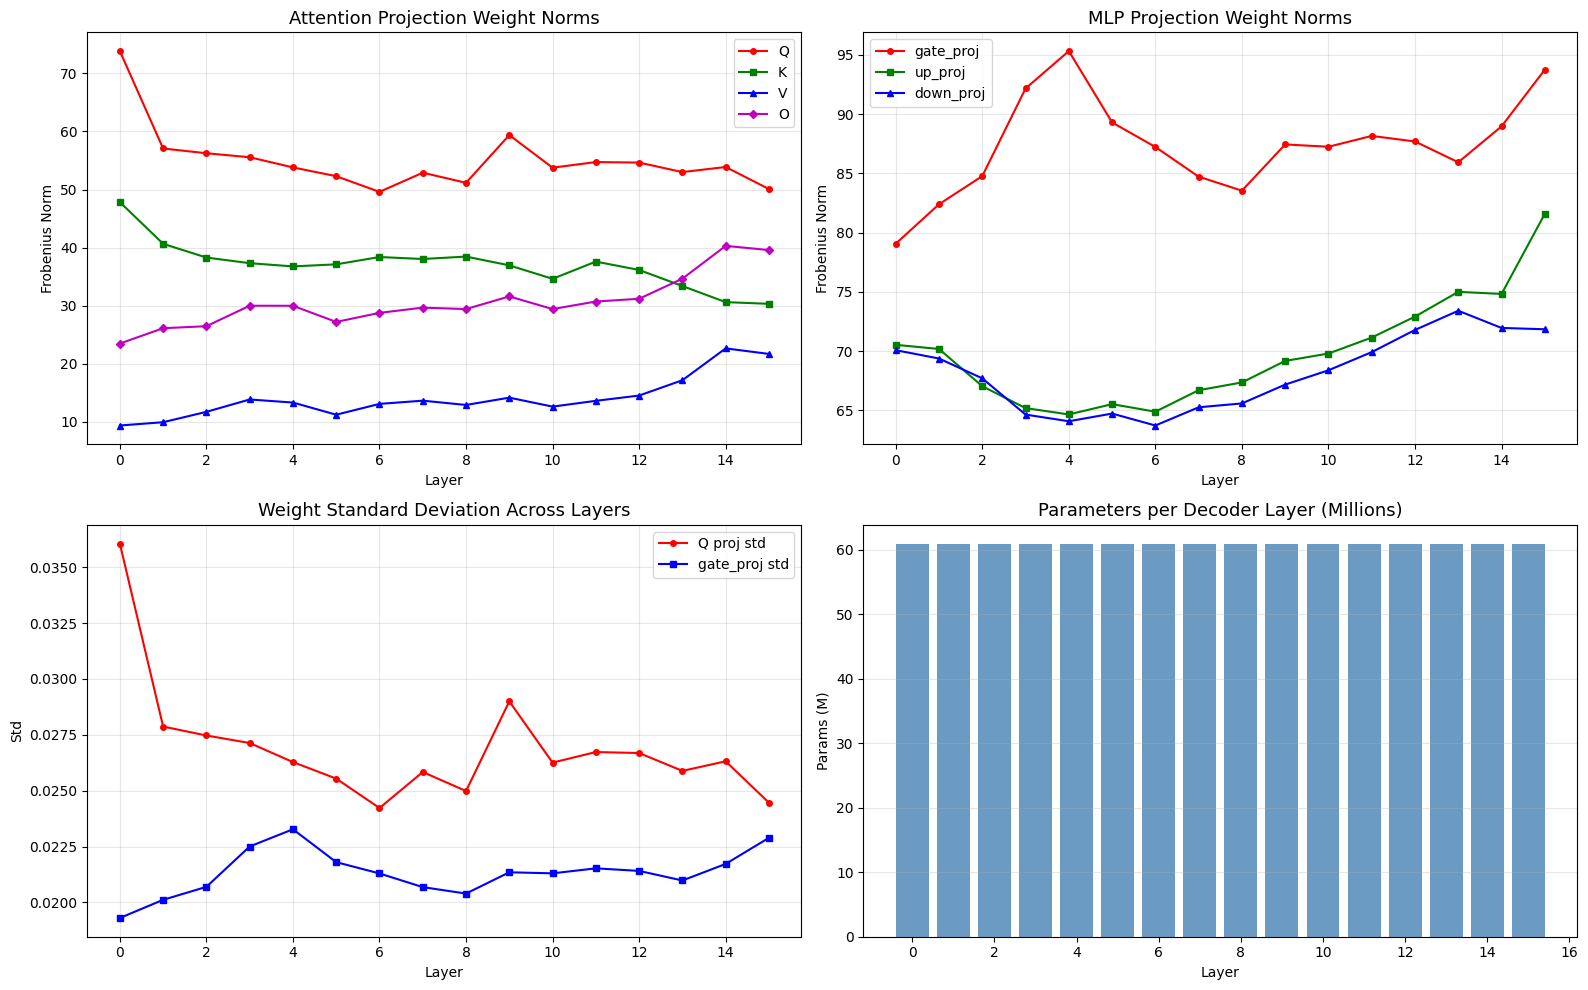

In [36]:
# ─── Weight Norm Across Layers ───
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Collect norms per layer
q_norms, k_norms, v_norms, o_norms = [], [], [], []
gate_norms, up_norms, down_norms = [], [], []

for i in range(num_layers):
    layer = decoder_layers[i]
    q_norms.append(layer.self_attn.q_proj.weight.detach().float().norm().item())
    k_norms.append(layer.self_attn.k_proj.weight.detach().float().norm().item())
    v_norms.append(layer.self_attn.v_proj.weight.detach().float().norm().item())
    o_norms.append(layer.self_attn.o_proj.weight.detach().float().norm().item())
    gate_norms.append(layer.mlp.gate_proj.weight.detach().float().norm().item())
    up_norms.append(layer.mlp.up_proj.weight.detach().float().norm().item())
    down_norms.append(layer.mlp.down_proj.weight.detach().float().norm().item())

x = range(num_layers)

# Attention projections
axes[0, 0].plot(x, q_norms, 'r-o', markersize=4, label='Q')
axes[0, 0].plot(x, k_norms, 'g-s', markersize=4, label='K')
axes[0, 0].plot(x, v_norms, 'b-^', markersize=4, label='V')
axes[0, 0].plot(x, o_norms, 'm-D', markersize=4, label='O')
axes[0, 0].set_title('Attention Projection Weight Norms', fontsize=13)
axes[0, 0].set_xlabel('Layer')
axes[0, 0].set_ylabel('Frobenius Norm')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# MLP projections
axes[0, 1].plot(x, gate_norms, 'r-o', markersize=4, label='gate_proj')
axes[0, 1].plot(x, up_norms, 'g-s', markersize=4, label='up_proj')
axes[0, 1].plot(x, down_norms, 'b-^', markersize=4, label='down_proj')
axes[0, 1].set_title('MLP Projection Weight Norms', fontsize=13)
axes[0, 1].set_xlabel('Layer')
axes[0, 1].set_ylabel('Frobenius Norm')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Weight std per layer
q_stds = [decoder_layers[i].self_attn.q_proj.weight.detach().float().std().item() for i in range(num_layers)]
mlp_stds = [decoder_layers[i].mlp.gate_proj.weight.detach().float().std().item() for i in range(num_layers)]
axes[1, 0].plot(x, q_stds, 'r-o', markersize=4, label='Q proj std')
axes[1, 0].plot(x, mlp_stds, 'b-s', markersize=4, label='gate_proj std')
axes[1, 0].set_title('Weight Standard Deviation Across Layers', fontsize=13)
axes[1, 0].set_xlabel('Layer')
axes[1, 0].set_ylabel('Std')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Parameter count per layer
layer_param_counts = []
for i in range(num_layers):
    layer_p = sum(p.numel() for p in decoder_layers[i].parameters())
    layer_param_counts.append(layer_p)

axes[1, 1].bar(x, [p / 1e6 for p in layer_param_counts], color='steelblue', alpha=0.8)
axes[1, 1].set_title('Parameters per Decoder Layer (Millions)', fontsize=13)
axes[1, 1].set_xlabel('Layer')
axes[1, 1].set_ylabel('Params (M)')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

---
## 9. 👁️ Attention Pattern Visualization

Model ကို actual text input ပေးပြီး attention weights (patterns) ကို visualize လုပ်ပါမယ်။  
Decoder model ဖြစ်တဲ့အတွက် **causal (lower-triangular) attention mask** ကို သုံးထားပါတယ်။

In [44]:
# ─── Extract Attention Weights ───
test_input = "Artificial intelligence is transforming the world of technology and science."

inputs = tokenizer(test_input, return_tensors="pt").to(model.device)
input_ids = inputs["input_ids"]
tokens_list = tokenizer.convert_ids_to_tokens(input_ids[0])

print(f"Input text  : '{test_input}'")
print(f"Token count : {len(tokens_list)}")
print(f"Tokens      : {tokens_list}")

# Forward pass with attention outputs
with torch.no_grad():
    outputs = model(
        **inputs,
        output_attentions=True,
        output_hidden_states=True,
    )

# outputs.attentions: tuple of (batch, num_heads, seq_len, seq_len) for each layer
print(f"\nNumber of attention layers returned: {len(outputs.attentions)}")
print(f"Attention shape per layer: {outputs.attentions[0].shape}")
print(f"  → (batch_size, num_heads, seq_len, seq_len)")

# Hidden states
print(f"\nNumber of hidden states: {len(outputs.hidden_states)} (input_embed + {num_layers} layers)")
print(f"Hidden state shape: {outputs.hidden_states[0].shape}")

Input text  : 'Artificial intelligence is transforming the world of technology and science.'
Token count : 13
Tokens      : ['<|begin_of_text|>', 'Art', 'ificial', 'Ġintelligence', 'Ġis', 'Ġtransforming', 'Ġthe', 'Ġworld', 'Ġof', 'Ġtechnology', 'Ġand', 'Ġscience', '.']

Number of attention layers returned: 16
Attention shape per layer: torch.Size([1, 32, 13, 13])
  → (batch_size, num_heads, seq_len, seq_len)

Number of hidden states: 17 (input_embed + 16 layers)
Hidden state shape: torch.Size([1, 13, 2048])


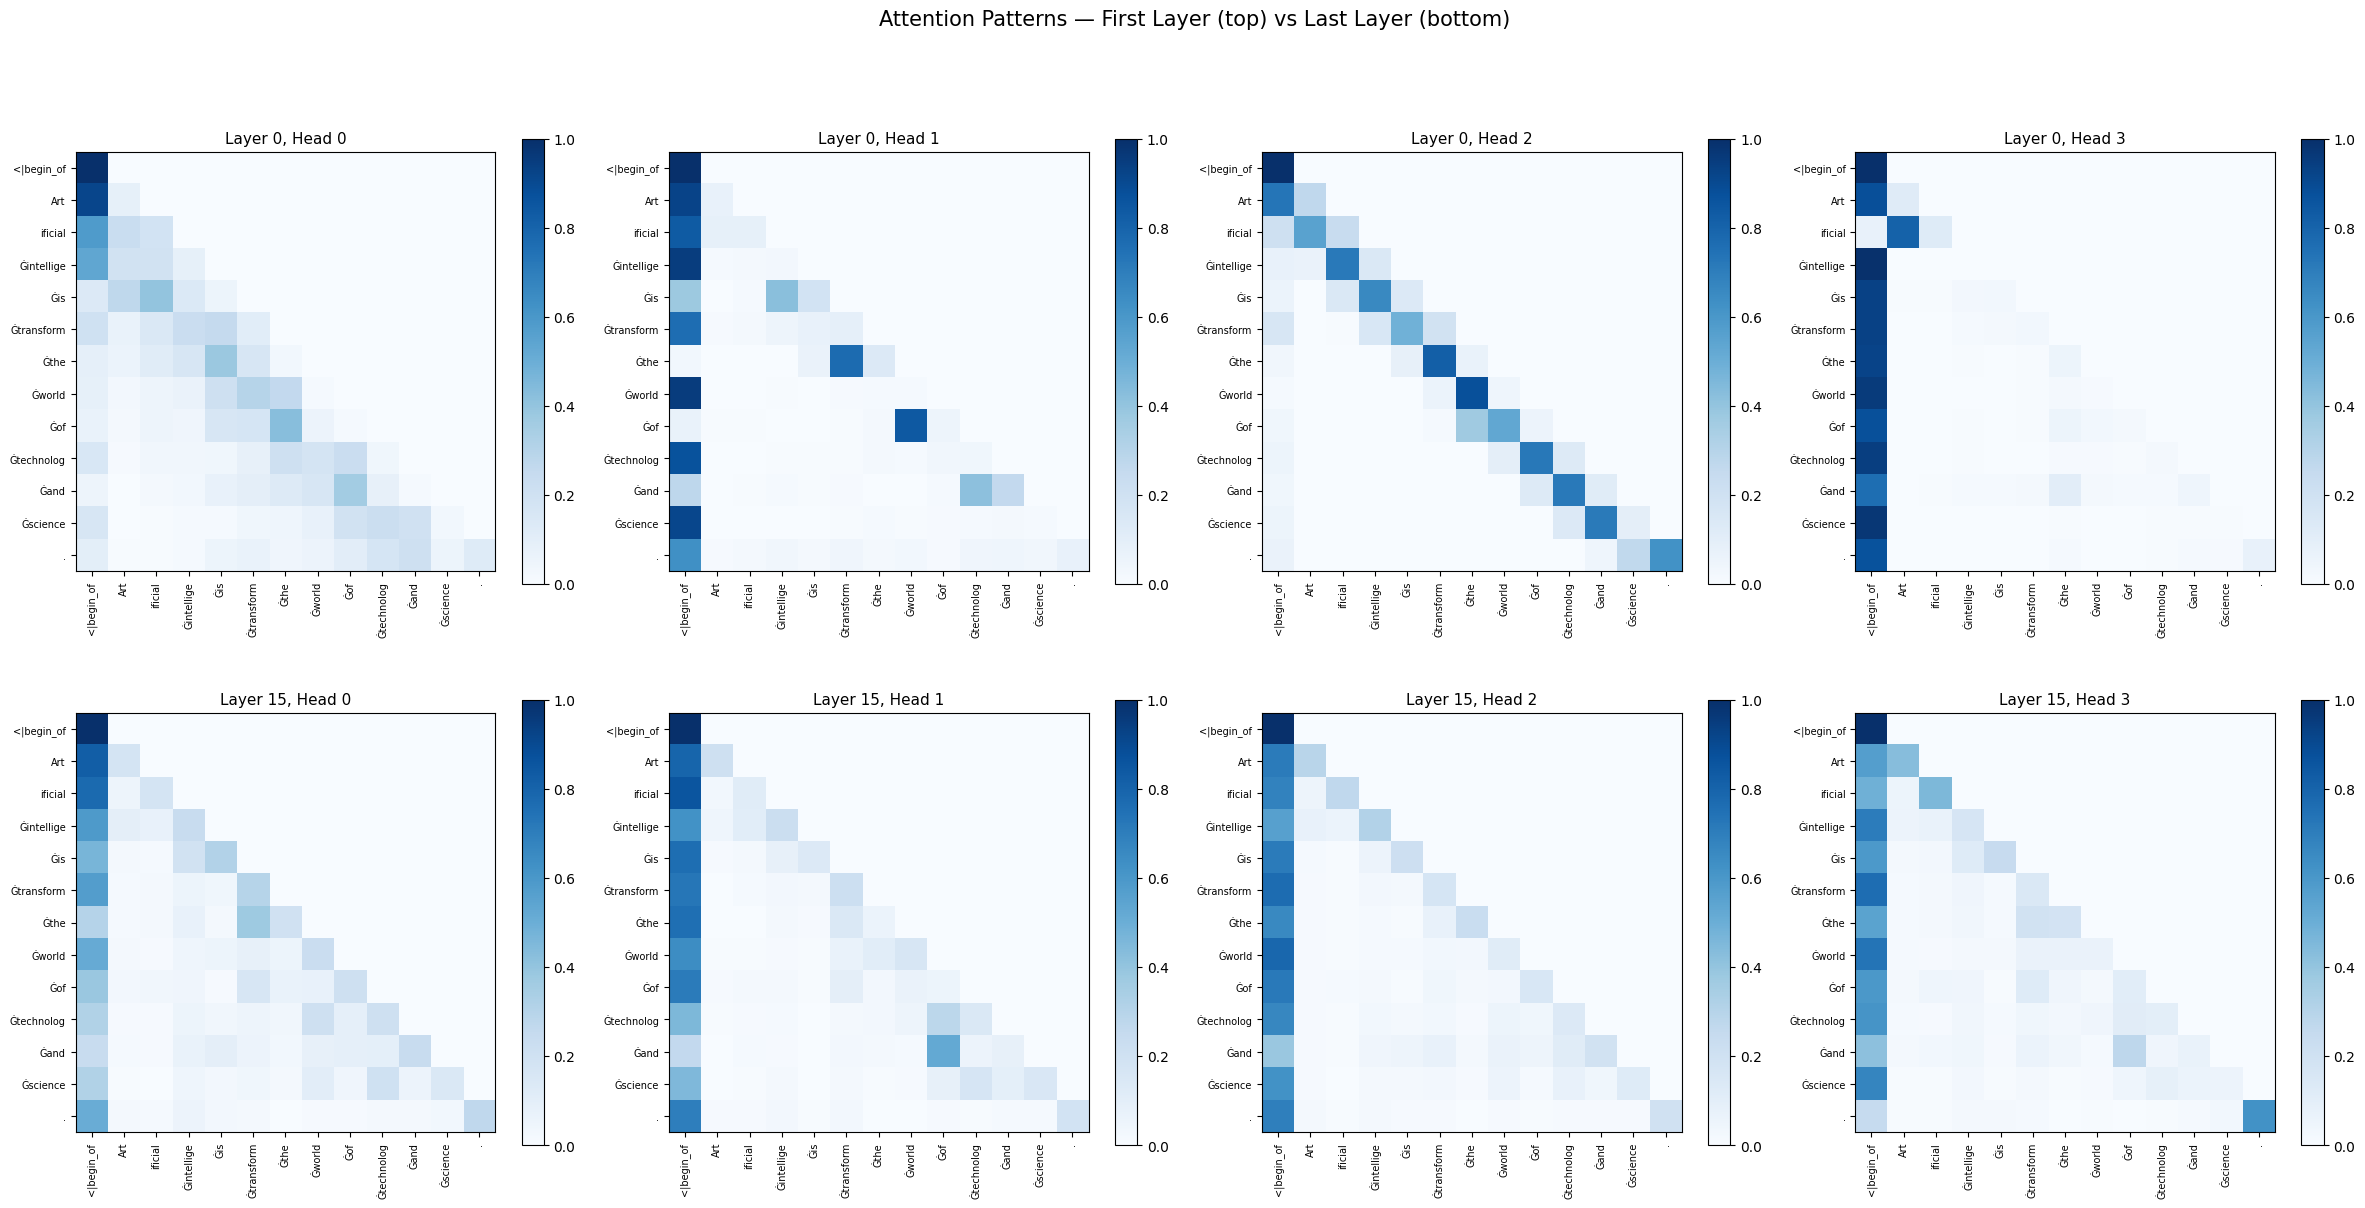

In [45]:
# ─── Attention Heatmaps: First & Last Layers ───
fig, axes = plt.subplots(2, 4, figsize=(24, 12))

for row, layer_idx in enumerate([0, num_layers - 1]):
    attn_weights = outputs.attentions[layer_idx][0].detach().float().cpu()  # (num_heads, seq, seq)

    for col, head_idx in enumerate([0, 1, 2, 3]):
        if head_idx < attn_weights.shape[0]:
            ax = axes[row, col]
            im = ax.imshow(attn_weights[head_idx].numpy(), cmap='Blues', vmin=0)
            ax.set_title(f'Layer {layer_idx}, Head {head_idx}', fontsize=11)
            ax.set_xticks(range(len(tokens_list)))
            ax.set_yticks(range(len(tokens_list)))

            display_tokens = [t[:10] for t in tokens_list]
            ax.set_xticklabels(display_tokens, rotation=90, fontsize=7)
            ax.set_yticklabels(display_tokens, fontsize=7)
            plt.colorbar(im, ax=ax, shrink=0.8)

fig.suptitle('Attention Patterns — First Layer (top) vs Last Layer (bottom)', fontsize=15, y=1.02)
plt.tight_layout()
plt.show()

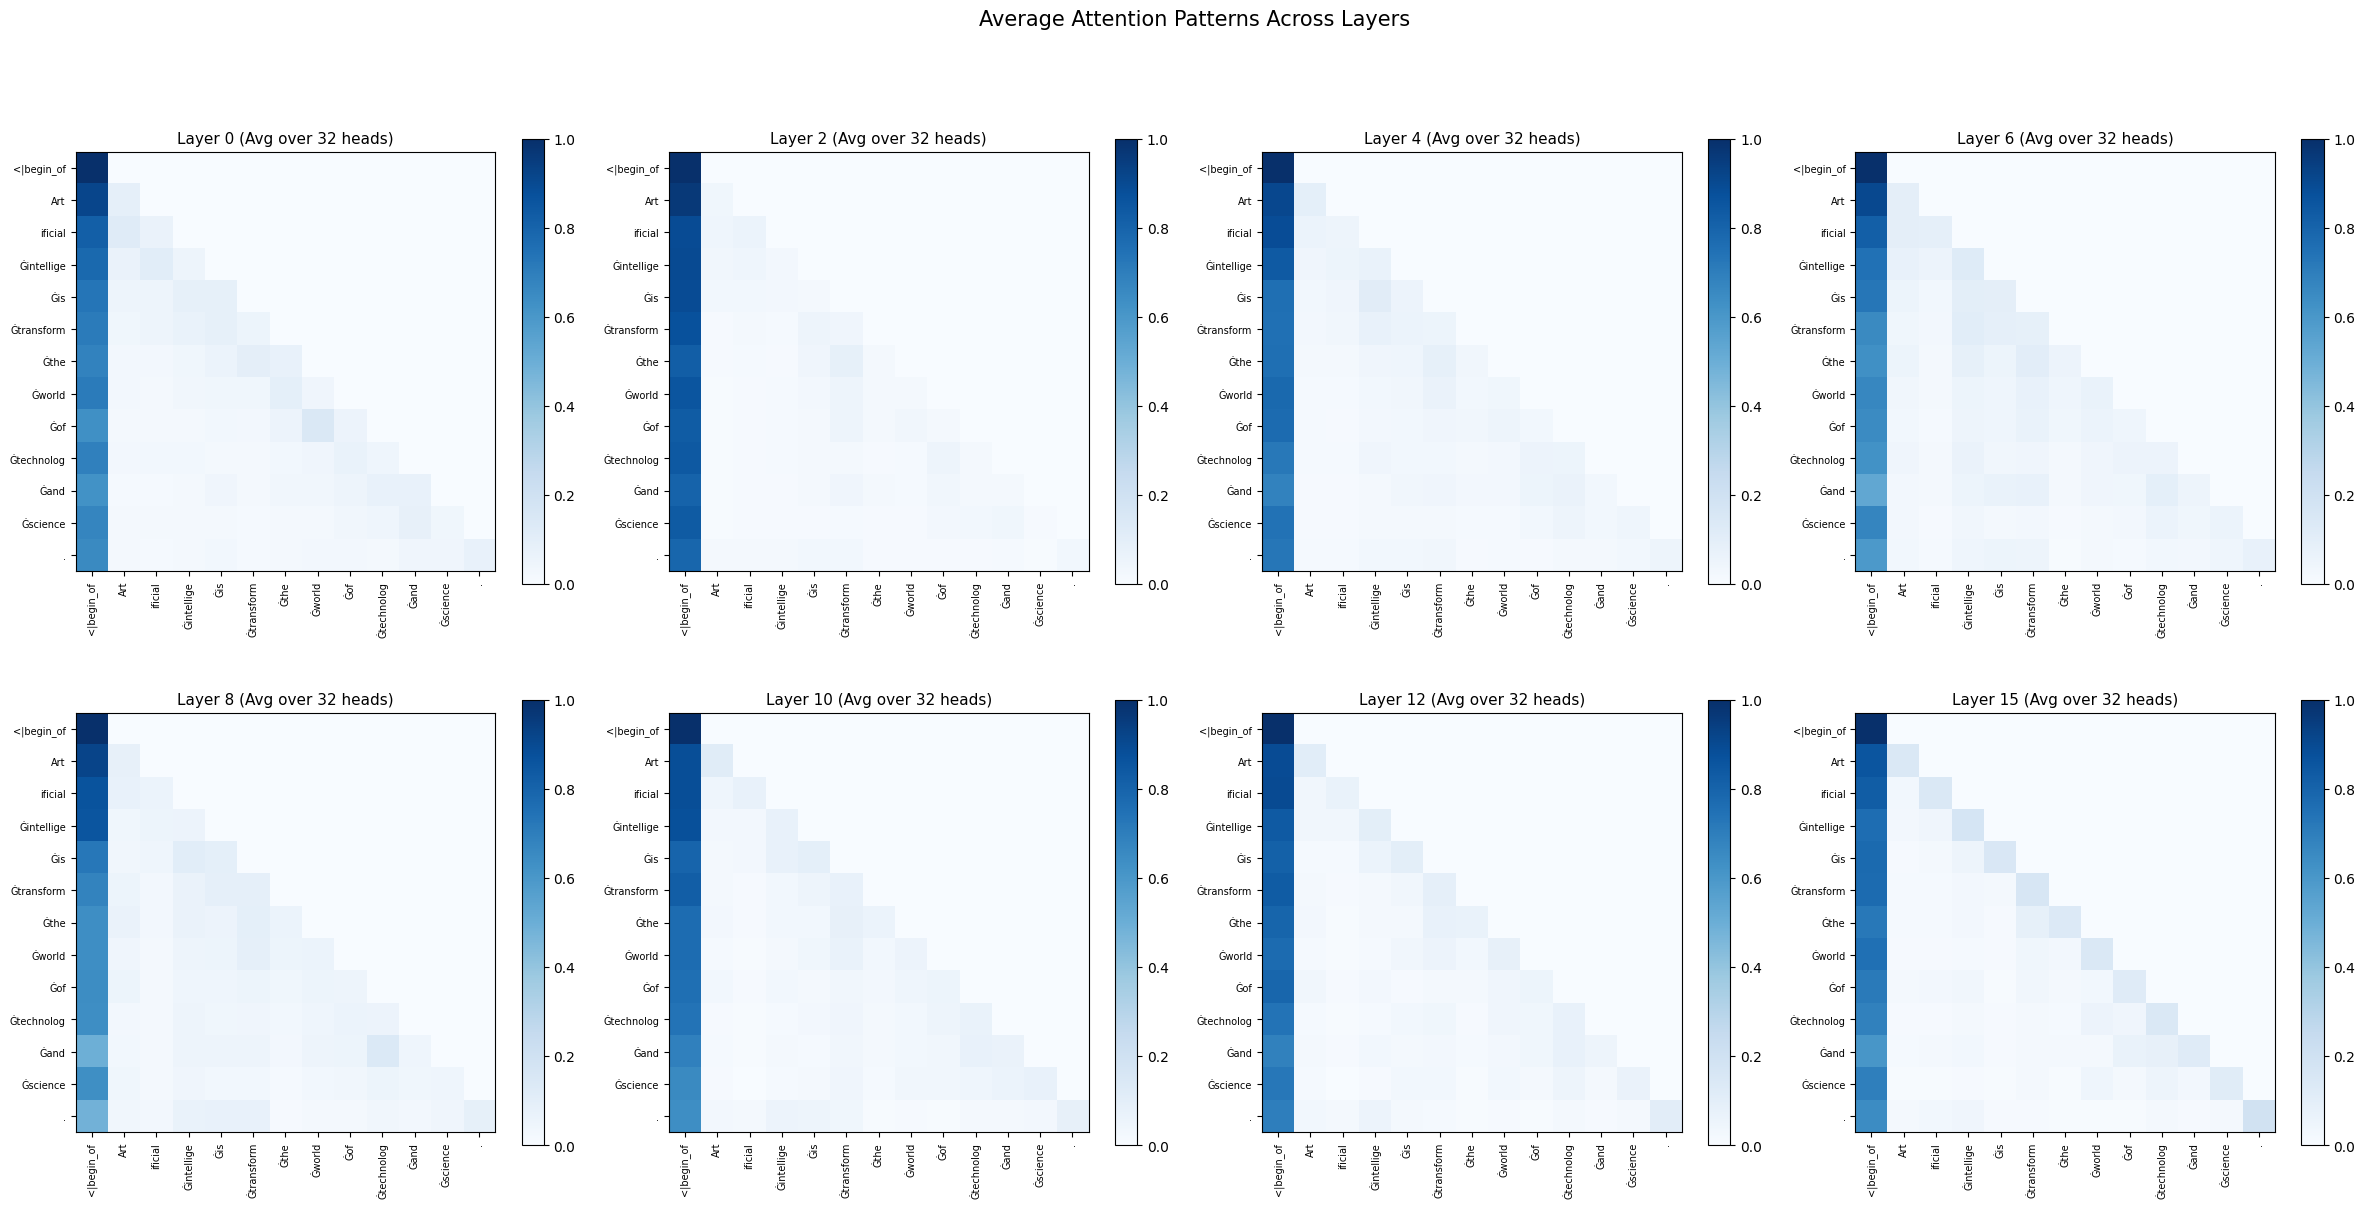

In [50]:
# ─── Average Attention Pattern Across Heads per Layer ───
fig, axes = plt.subplots(2, 4, figsize=(24, 12))

# Select 8 evenly spaced layers
layer_indices = np.linspace(0, num_layers - 1, 8, dtype=int)

for idx, layer_idx in enumerate(layer_indices):
    row, col = idx // 4, idx % 4
    attn_weights = outputs.attentions[layer_idx][0].detach().float().cpu()
    avg_attn = attn_weights.mean(dim=0)  # Average across heads

    ax = axes[row, col]
    im = ax.imshow(avg_attn.numpy(), cmap='Blues', vmin=0)
    ax.set_title(f'Layer {layer_idx} (Avg over {attn_weights.shape[0]} heads)', fontsize=11)

    display_tokens = [t[:10] for t in tokens_list]
    ax.set_xticks(range(len(tokens_list)))
    ax.set_yticks(range(len(tokens_list)))
    ax.set_xticklabels(display_tokens, rotation=90, fontsize=7)
    ax.set_yticklabels(display_tokens, fontsize=7)
    plt.colorbar(im, ax=ax, shrink=0.8)

fig.suptitle('Average Attention Patterns Across Layers', fontsize=15, y=1.02)
plt.tight_layout()
plt.show()

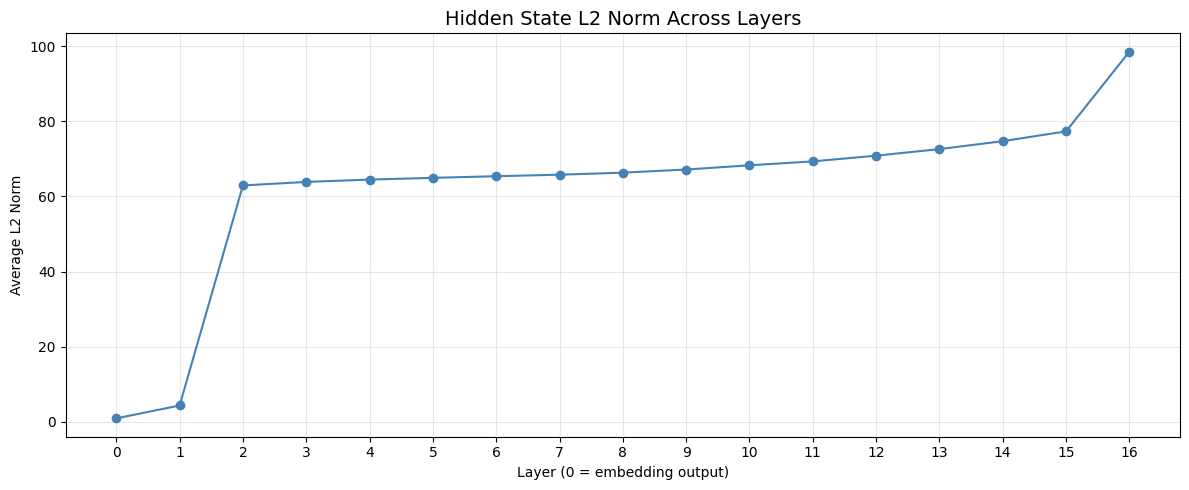

In [51]:
# ─── Hidden State Norms Across Layers ───
hidden_norms = []
for h in outputs.hidden_states:
    # h shape: (batch, seq_len, hidden_size)
    norm = h[0].detach().float().norm(dim=-1).mean().cpu().item()
    hidden_norms.append(norm)

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(range(len(hidden_norms)), hidden_norms, 'o-', color='steelblue', markersize=6)
ax.set_title('Hidden State L2 Norm Across Layers', fontsize=14)
ax.set_xlabel('Layer (0 = embedding output)')
ax.set_ylabel('Average L2 Norm')
ax.grid(True, alpha=0.3)
ax.set_xticks(range(0, len(hidden_norms), max(1, len(hidden_norms) // 16)))
plt.tight_layout()
plt.show()

---
## 10. 🚀 Generation Pipeline & Inference Test

Model ကို actual text generation task ပေးပြီး inference behavior ကို စစ်ဆေးပါမယ်။

In [54]:
# ─── Text Generation Tests ───
def generate_response(messages, max_new_tokens=256, temperature=0.7, top_p=0.9):
    """Generate response using chat template."""
    chat_out = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        return_tensors="pt",
        return_dict=True,
    )
    input_ids = chat_out["input_ids"].to(model.device)
    attention_mask = chat_out.get("attention_mask", None)
    if attention_mask is not None:
        attention_mask = attention_mask.to(model.device)

    with torch.no_grad():
        output_ids = model.generate(
            input_ids,
            attention_mask=attention_mask,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            top_p=top_p,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id,
        )

    # Decode only the generated part
    generated = output_ids[0][input_ids.shape[-1]:]
    response = tokenizer.decode(generated, skip_special_tokens=True)
    return response, len(generated)

print("═" * 70)
print("  GENERATION TESTS")
print("═" * 70)

══════════════════════════════════════════════════════════════════════
  GENERATION TESTS
══════════════════════════════════════════════════════════════════════


In [55]:
# ─── Test 1: General Knowledge ───
messages = [
    {"role": "system", "content": "You are a helpful assistant. Answer concisely."},
    {"role": "user", "content": "What is a transformer model in deep learning? Explain in 3 sentences."},
]

response, num_tokens = generate_response(messages, max_new_tokens=150)
print(f"\n🧪 Test 1 — General Knowledge:")
print(f"Q: What is a transformer model in deep learning?")
print(f"A: {response}")
print(f"   (Generated {num_tokens} tokens)")


🧪 Test 1 — General Knowledge:
Q: What is a transformer model in deep learning?
A: A transformer model is a type of neural network architecture introduced in the paper "Attention Is All You Need" by Vaswani et al. It's designed to handle sequential data, such as text, by modeling the relationships between different parts of the input sequence using self-attention mechanisms. This allows the model to capture context and relationships between elements in the data, enabling it to perform tasks like language translation and question-answering with high accuracy.
   (Generated 91 tokens)


In [56]:
# ─── Test 2: Code Generation ───
messages = [
    {"role": "system", "content": "You are a Python coding assistant."},
    {"role": "user", "content": "Write a Python function to check if a number is prime."},
]

response, num_tokens = generate_response(messages, max_new_tokens=200)
print(f"\n🧪 Test 2 — Code Generation:")
print(f"Q: Write a Python function to check if a number is prime.")
print(f"A: {response}")
print(f"   (Generated {num_tokens} tokens)")


🧪 Test 2 — Code Generation:
Q: Write a Python function to check if a number is prime.
A: **Prime Number Checker Function**

Here's a Python function that checks if a given number is prime:

```python
def is_prime(n: int) -> bool:
    """
    Checks if a number is prime.

    Args:
        n (int): The number to check.

    Returns:
        bool: True if the number is prime, False otherwise.
    """
    if n <= 1:
        return False
    for i in range(2, int(n ** 0.5) + 1):
        if n % i == 0:
            return False
    return True
```

**Explanation**
---------------

This function takes an integer `n` as input and checks if it's prime. Here's how it works:

1. If `n` is less than or equal to 1, it's not prime, so we return False.
2. We only need to check up to the square root of `n` because a larger factor
   (Generated 200 tokens)


In [57]:
# ─── Test 3: Reasoning ───
messages = [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": "If I have 3 apples and give away 1, then buy 5 more, how many apples do I have?"},
]

response, num_tokens = generate_response(messages, max_new_tokens=100)
print(f"\n🧪 Test 3 — Reasoning:")
print(f"Q: If I have 3 apples and give away 1, then buy 5 more, how many?")
print(f"A: {response}")
print(f"   (Generated {num_tokens} tokens)")


🧪 Test 3 — Reasoning:
Q: If I have 3 apples and give away 1, then buy 5 more, how many?
A: You start with 3 apples.

You give away 1 apple, so you have 3 - 1 = 2 apples left.

Then, you buy 5 more apples, so you now have 2 + 5 = 7 apples.
   (Generated 52 tokens)


In [58]:
# ─── Token Probability Analysis ───
print("\n📊 Next-Token Probability Analysis:")
print("=" * 60)

test_prompt = "The meaning of life is"
input_ids = tokenizer(test_prompt, return_tensors="pt").input_ids.to(model.device)

with torch.no_grad():
    outputs = model(input_ids)
    logits = outputs.logits[0, -1, :]  # Last token's logits
    probs = torch.softmax(logits.float(), dim=-1)

# Top-20 predictions
top_k = 20
top_probs, top_indices = torch.topk(probs, top_k)

print(f"\nPrompt: '{test_prompt}'")
print(f"\nTop-{top_k} Next Token Predictions:")
print(f"{'Rank':<6} {'Token':<20} {'Probability':>12} {'Log Prob':>10}")
print("-" * 50)
for i in range(top_k):
    token = tokenizer.decode(top_indices[i].item())
    prob = top_probs[i].item()
    log_prob = torch.log(top_probs[i]).item()
    bar = '█' * int(prob * 100)
    print(f"  {i+1:<4} '{token}'{'':>{18-len(token)}} {prob:>10.4f}   {log_prob:>8.4f}  {bar}")

# Entropy
entropy = -(probs * torch.log(probs + 1e-10)).sum().item()
print(f"\n  Entropy of distribution: {entropy:.4f} nats")
print(f"  Perplexity: {np.exp(entropy):.2f}")


📊 Next-Token Probability Analysis:

Prompt: 'The meaning of life is'

Top-20 Next Token Predictions:
Rank   Token                 Probability   Log Prob
--------------------------------------------------
  1    ' a'                     0.3114    -1.1665  ███████████████████████████████
  2    ' often'                 0.1591    -1.8384  ███████████████
  3    ' not'                   0.1110    -2.1978  ███████████
  4    ' to'                    0.0950    -2.3540  █████████
  5    ' what'                  0.0219    -3.8228  ██
  6    ' different'             0.0205    -3.8853  ██
  7    ' subjective'            0.0176    -4.0415  █
  8    ' the'                   0.0157    -4.1509  █
  9    ' complex'               0.0137    -4.2915  █
  10   ' one'                   0.0108    -4.5259  █
  11   ' debated'               0.0099    -4.6197  
  12   ' still'                 0.0087    -4.7447  
  13   ' indeed'                0.0054    -5.2212  
  14   ' an'                    0.0051    -5.

---
## 11. 📋 Summary & Key Findings

Llama 3.2-1B-Instruct model ရဲ့ decoder architecture ကို analysis လုပ်ပြီးပြီဆိုတော့ key findings တွေကို အနှစ်ချုပ်ပါမယ်။

In [59]:
# ─── Architecture Summary Table ───
print("╔" + "═" * 68 + "╗")
print("║" + "  LLAMA 3.2-1B-INSTRUCT — ARCHITECTURE SUMMARY".center(68) + "║")
print("╠" + "═" * 68 + "╣")

summary = [
    ("Model Type", "Decoder-Only Transformer (Causal LM)"),
    ("Total Parameters", f"{total_params:,} ({total_params/1e9:.3f}B)"),
    ("Hidden Size", f"{hidden_size}"),
    ("Decoder Layers", f"{num_layers}"),
    ("Attention Heads (Q)", f"{num_heads}"),
    ("KV Heads", f"{num_kv_heads} (GQA ratio: {num_heads//num_kv_heads}:1)"),
    ("Head Dimension", f"{head_dim}"),
    ("FFN Intermediate Size", f"{intermediate_size} ({expansion_ratio:.2f}x expansion)"),
    ("Vocabulary Size", f"{config.vocab_size:,}"),
    ("Max Context Length", f"{config.max_position_embeddings:,}"),
    ("Attention Type", "Grouped-Query Attention (GQA)"),
    ("Position Encoding", f"RoPE (theta={rope_theta:,.0f})"),
    ("FFN Activation", "SwiGLU (SiLU gate)"),
    ("Normalization", f"RMSNorm (eps={config.rms_norm_eps})"),
    ("Weight Tying", f"{config.tie_word_embeddings}"),
]

for key, value in summary:
    print(f"║  {key:<28} │ {value:<37} ║")

print("╠" + "═" * 68 + "╣")
print("║" + "  DATA FLOW (per decoder layer)".center(68) + "║")
print("╠" + "═" * 68 + "╣")

flow_steps = [
    "1. Input x",
    "2. residual = x",
    "3. x = RMSNorm(x)                    [input_layernorm]",
    "4. x = GQA_SelfAttention(x)           [Q,K,V proj → RoPE → Attn → O proj]",
    "5. x = x + residual                   [Residual Connection #1]",
    "6. residual = x",
    "7. x = RMSNorm(x)                    [post_attention_layernorm]",
    "8. x = SwiGLU_MLP(x)                 [gate↑up↓ projections]",
    "9. x = x + residual                   [Residual Connection #2]",
]

for step in flow_steps:
    print(f"║  {step:<66} ║")

print("╠" + "═" * 68 + "╣")
print("║" + "  After all layers:".center(68) + "║")
print(f"║  {'10. x = RMSNorm(x)        [final norm]':<66} ║")
print(f"║  {'11. logits = lm_head(x)   [project to vocab]':<66} ║")
print("╚" + "═" * 68 + "╝")

╔════════════════════════════════════════════════════════════════════╗
║             LLAMA 3.2-1B-INSTRUCT — ARCHITECTURE SUMMARY           ║
╠════════════════════════════════════════════════════════════════════╣
║  Model Type                   │ Decoder-Only Transformer (Causal LM)  ║
║  Total Parameters             │ 1,235,814,400 (1.236B)                ║
║  Hidden Size                  │ 2048                                  ║
║  Decoder Layers               │ 16                                    ║
║  Attention Heads (Q)          │ 32                                    ║
║  KV Heads                     │ 8 (GQA ratio: 4:1)                    ║
║  Head Dimension               │ 64                                    ║
║  FFN Intermediate Size        │ 8192 (4.00x expansion)                ║
║  Vocabulary Size              │ 128,256                               ║
║  Max Context Length           │ 131,072                               ║
║  Attention Type               │ Grouped-Query

In [60]:
# ─── Final Architecture Diagram ───
print("\n🏗️  Llama 3.2-1B-Instruct — Visual Architecture Flow")
print("=" * 60)
print("""
  Input Token IDs
       │
       ▼
  ┌─────────────────┐
  │   embed_tokens   │  Vocabulary → d_model ({hidden_size})
  │   ({vocab_size:,} × {hidden_size})  │
  └────────┬────────┘
           │
           ▼
  ┌─────────────────────────────────────────┐
  │         Decoder Layer × {num_layers}           │
  │  ┌───────────────────────────────────┐  │
  │  │  RMSNorm (input_layernorm)        │  │
  │  │          │                        │  │
  │  │  Grouped-Query Attention (GQA)    │  │
  │  │    Q: {num_heads} heads  KV: {num_kv_heads} heads          │  │
  │  │    head_dim: {head_dim}   +RoPE            │  │
  │  │          │                        │  │
  │  │  + Residual Connection            │  │
  │  │          │                        │  │
  │  │  RMSNorm (post_attn_layernorm)    │  │
  │  │          │                        │  │
  │  │  SwiGLU MLP                       │  │
  │  │    gate: {hidden_size}→{intermediate_size}              │  │
  │  │    up:   {hidden_size}→{intermediate_size}              │  │
  │  │    down:  {intermediate_size}→{hidden_size}             │  │
  │  │          │                        │  │
  │  │  + Residual Connection            │  │
  │  └───────────────────────────────────┘  │
  └────────────────────┬────────────────────┘
                       │
                       ▼
  ┌─────────────────────────┐
  │    RMSNorm (final)      │
  └───────────┬─────────────┘
              │
              ▼
  ┌─────────────────────────┐
  │   lm_head (Linear)      │  d_model → vocab_size
  │   ({hidden_size} → {vocab_size:,})    │
  └───────────┬─────────────┘
              │
              ▼
         Output Logits
     ({vocab_size:,} probabilities)
""".format(
    hidden_size=hidden_size,
    vocab_size=config.vocab_size,
    num_layers=num_layers,
    num_heads=num_heads,
    num_kv_heads=num_kv_heads,
    head_dim=head_dim,
    intermediate_size=intermediate_size,
))


🏗️  Llama 3.2-1B-Instruct — Visual Architecture Flow

  Input Token IDs
       │
       ▼
  ┌─────────────────┐
  │   embed_tokens   │  Vocabulary → d_model (2048)
  │   (128,256 × 2048)  │
  └────────┬────────┘
           │
           ▼
  ┌─────────────────────────────────────────┐
  │         Decoder Layer × 16           │
  │  ┌───────────────────────────────────┐  │
  │  │  RMSNorm (input_layernorm)        │  │
  │  │          │                        │  │
  │  │  Grouped-Query Attention (GQA)    │  │
  │  │    Q: 32 heads  KV: 8 heads          │  │
  │  │    head_dim: 64   +RoPE            │  │
  │  │          │                        │  │
  │  │  + Residual Connection            │  │
  │  │          │                        │  │
  │  │  RMSNorm (post_attn_layernorm)    │  │
  │  │          │                        │  │
  │  │  SwiGLU MLP                       │  │
  │  │    gate: 2048→8192              │  │
  │  │    up:   2048→8192              │  │
  │  │    down:  8192→2048  

In [61]:
# ─── Clean up GPU memory ───
print("🧹 Cleaning up...")
if torch.cuda.is_available():
    print(f"  GPU memory before cleanup: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
    del outputs
    torch.cuda.empty_cache()
    print(f"  GPU memory after cleanup : {torch.cuda.memory_allocated() / 1e9:.2f} GB")

print("\n✅ Analysis complete!")

🧹 Cleaning up...
  GPU memory before cleanup: 3.57 GB
  GPU memory after cleanup : 3.57 GB

✅ Analysis complete!
